# What's new since last year's UGM? 2025 RDKit UGM Edition

Not an exhaustive list, just some examples.
Covers 2024.09, 2025.03, and the forthcoming 2025.09 release.

## Documentation

[Getting started with contributing](https://www.rdkit.org/docs/GettingStartedWithContributing.html)

## Big code changes




### Backwards incompatible changes
(Ongoing)

We are gradually making changes to the code that may be either backwards incompatible or may change the default results. These are documented in a section of the release notes and are generally tagged with `Changes Results` in github.

Here are examples from the most recent three releases covered here:

#### 2025.09 (in progress)


#### 2025.03
- The order of combinations returned by Chem.Pharm2D.Utils.GetUniqueCombinations
  has changed to be in numerical order. The combinations themselves are
  unchanged.
- The MaeWriter class will now throw when attempting to write an empty Mol or
  when there are errors during the writing (e.g. kekulization errors). Previous
  behavior was to log an error and return an empty string.
- AdjustQueryProperties now no longer ignores additional atom adjustments when
  makeAtomsGeneric is enabled.
- The functions getImplicitValence(), getNumImplicitHs(), getDegree(), and
  getTotalDegree(), now return 0 for atoms that are not associated with
  molecules (previously they threw exceptions)
- SMILES and RGroupDecomp JSON parsers were moved to their own translation
  units. This will require C++ code using those JSON parsers to be added
  #include directives for GraphMol/SmilesParse/SmilesJSONParsers.h and
  GraphMol/RGroupDecomposition/RGroupDecompJSONParsers.h, respectively.
- Replaced enums in the signatures of MolToCXSmiles and
  updateCXSmilesFieldsFromJSON with the underlying types. This may require
  existing C++ code using those functions to be updated accordingly.
- HasPropWithValueQueryBase used RDKit::Dict::Pair to return data used for
  serializing object in a molecule  pickle.  This has been changed to
  RDKit::PairHolder which automatically manages memory.
- The colors of annotations on atoms and bonds are now controlled by the drawing
  options `atomNoteColour` and `bondNoteColour` instead of the general
  `annotationColour`.
- When writing SMILES, organic subset atoms which are bonded to "metals" will 
  always be written in square brackets, i.e. with their H count explicit. Here 
  the definition of "metal" is any atom matching an "M" query (the corresponding 
  SMARTS is `[!#0!#1!#2!#5!#6!#7!#8!#9!#10!#14!#15!#16!#17!#18!#33!#34!#35!#36!#52!#53!#54!#85!#86]`)

#### 2024.09
```
- The SMARTS for the unbranched alkanes in the fragment descriptors has been corrected. This descriptor will now frequently return different results.
- The SimilarityMap functions GetSimilarityMapFromWeights(), GetSimilarityMapForFingerprint(), and GetSimilarityMapForModel() all now require an rdMolDraw2D drawing object to be passed in.
- A bug fix in v2 of the tautomer and protomer hashes can lead to different results for these hashes. One less bond is now included in the tautomeric zone for systems like enamines/imines, so the v2 tautomer hash of the molecules `CN=CC` and `CNC=C` is now `[C]:[C]:[N]-[CH3]_4_0` instead of `[C]:[C]:[N]:[C]_7_0`
- The way valences are checked and implicit valences are calculated has been changed. The results should generally be the same as before, but some previously allowed valence states have been removed. These include: five-valent [C+], valence state 6 for the elements Al and Si, and valence state 7 for the elements P, As, Sb, and Bi.
- The GeneralMolSupplier has been moved to use the v2 API. The only change that should be necessary to end-user code is that the resulting supplier now returns std::unique_ptr<ROMol> instead of ROMol *.
```


# The Hydrogen mess

I made a mistake 24 years ago when I wrote the original RDKit `Atom` code: the way that implicit Hs are handled is confusing and more complex than it needs to be.

Here are some illustrations of that:

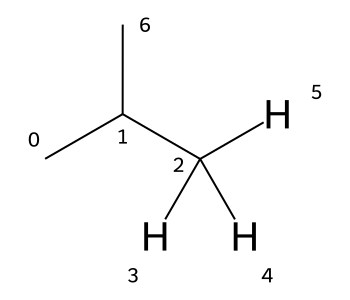

In [25]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = (350,300)

ps = Chem.SmilesParserParams()
ps.removeHs = False
m = Chem.MolFromSmiles('CC(C([H])([H])[H])[CH3]',ps)
m

In [26]:
m.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 3 imp: 1 hyb: SP3
	2 6 C chg: 0  deg: 4 exp: 4 imp: 0 hyb: SP3
	3 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	4 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	5 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	6 6 C chg: 0  deg: 1 exp: 4 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 2->3 order: 1
	3 2->4 order: 1
	4 2->5 order: 1
	5 1->6 order: 1


In [27]:
for aidx in (0,2,6):
    at = m.GetAtomWithIdx(aidx)
    print(f'{aidx}: implicit: {at.GetNumImplicitHs()}, explicit: {at.GetNumExplicitHs()}, total: {at.GetTotalNumHs(includeNeighbors=True)}')

0: implicit: 3, explicit: 0, total: 3
2: implicit: 0, explicit: 0, total: 3
6: implicit: 0, explicit: 3, total: 3


Of the three functions `atom.GetNumImplicitHs()`, `atom.GetNumExplicitHs`, and `atom.GetTotalNumHs()`, only `atom.GetTotalNumHs()` returns consistent results.

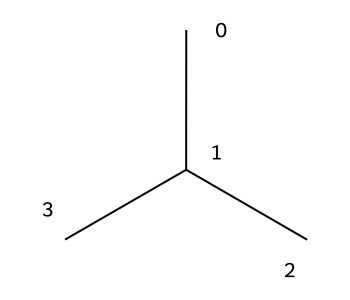

In [28]:
m_noh = Chem.RemoveHs(m)
m_noh

In [29]:
m_noh.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 3 imp: 1 hyb: SP3
	2 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	3 6 C chg: 0  deg: 1 exp: 4 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 1->3 order: 1


In [30]:
for aidx in (0,2,3):
    at = m_noh.GetAtomWithIdx(aidx)
    print(f'{aidx}: implicit: {at.GetNumImplicitHs()}, explicit: {at.GetNumExplicitHs()}, total: {at.GetTotalNumHs(includeNeighbors=True)}')

0: implicit: 3, explicit: 0, total: 3
2: implicit: 3, explicit: 0, total: 3
3: implicit: 0, explicit: 3, total: 3


It gets even more confusing:

In [31]:
m2 = Chem.MolFromSmiles('CC[H]')
m2.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 1 exp: 2 imp: 2 hyb: SP3
Bonds:
	0 0->1 order: 1


In [32]:
for aidx in (0,1):
    at = m2.GetAtomWithIdx(aidx)
    print(f'{aidx}: implicit: {at.GetNumImplicitHs()}, explicit: {at.GetNumExplicitHs()}, total: {at.GetTotalNumHs(includeNeighbors=True)}')

0: implicit: 3, explicit: 0, total: 3
1: implicit: 2, explicit: 1, total: 3


There is a similarly confusing situation with the results of `atom.GetExplicitValence()`, and `atom.GetImplicitValence()` (you see this above in the `exp` and `imp` entries of the debug output).

There is a reason for this mess, but it's not a good one.


## Solution (for your code)

Only use `atom.GetTotalNumHs()` and set the `includeNeighbors` argument to `True` if you want to find the total number of Hs connected to an atom or `False` if you know that you are working with hydrogen-suppressed molecules (the default in the RDKit) or if you only want to count the number of implicit Hs.

Use `atom.GetTotalValence()` if you want the sum of the valence of the atom's bonds and the number of implicit Hs.


## What we've changed in the RDKit itself.

Get rid of the confusing distinction between "implicit" and "explicit" Hs that are not present in the graph... these should all just be considered to be "implicit" Hs. Hs that are in the graph can be considered "explicit" if necessary.

Concrete API changes connected to this:
- remove the functions `atom.GetNumImplicitHs()` and `atom.GetNumExplicitHs()`
- remove the functions `atom.GetImplicitValence()` and `atom.GetExplicitValence()`
- add the function `atom.GetValence()` with options to return true implicit and true explicit valence values.

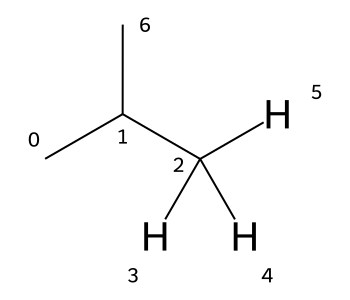

In [33]:
m = Chem.MolFromSmiles('CC(C([H])([H])[H])[CH3]',ps)
m

In [36]:
for aidx in (0,2,6):
    at = m.GetAtomWithIdx(aidx)
    print(f'{aidx}: total valence: {at.GetTotalValence()}, total Hs: {at.GetTotalNumHs(includeNeighbors=True)}')

0: total valence: 4, total Hs: 3
2: total valence: 4, total Hs: 3
6: total valence: 4, total Hs: 3


## The way forward

We started to make this change in the 2025.03 release and I hope to finish with the 2026.03 release.

There will also be a blog post or two on this topic and some extra documentation about how to identify parts of your code that may need to be changed and how to change them.

# Stereochemistry and the RDKit

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 350,300

import rdkit
print(rdkit.__version__)

2025.03.6


Start with a sample molecule with both atomic and bond stereochemistry

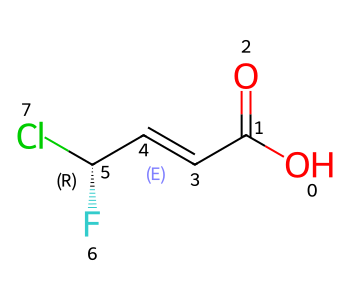

In [84]:
IPythonConsole.drawOptions.addAtomIndices = True

m = Chem.MolFromSmiles('OC(=O)/C=C/[C@H](F)Cl')
m

In [3]:
m.Debug()

Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP2
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: SP2
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
	6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 17 Cl chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1 conj?: 1
	1 1->2 order: 2 conj?: 1
	2 1->3 order: 1 dir: / conj?: 1
	3 3->4 order: 2 stereo: E ats: (1 5) conj?: 1
	4 4->5 order: 1 dir: /
	5 5->6 order: 1
	6 5->7 order: 1


## Aside: the RDKit's representation of stereochemistry

Here's the sample molecule

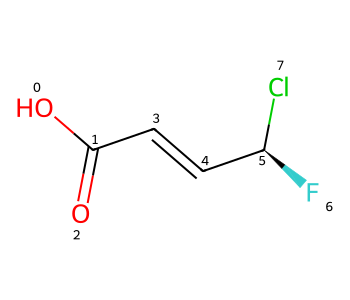

Let's start with the chirality around atom 5; here's what `mol.Debug()` showed:
```
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
```

The important information here is `chi` and `nbrs`, which tell us that if we look from atom 4 to atom 5, we need to rotate counter-clockwise to go from atom 6 to atom 7.

Here's what `mol.Debug()` showed for the double bond:
```
	3 3->4 order: 2 stereo: E ats: (1 5) conj?: 1
```
This tells us that atoms 1 and 5 are on opposite sides of the double bond.

If we use the new stereo perception code (see below) we get `TRANS` instead of `E` for the bond stereo, but the meaning of the `ats` information is the same.
```
	3 3->4 order: 2 stereo: TRANS ats: (1 5) conj?: 1
```


In [4]:
Chem.SetUseLegacyStereoPerception(False)
m = Chem.MolFromSmiles('OC(=O)/C=C/[C@H](F)Cl')
Chem.SetUseLegacyStereoPerception(True)

m.Debug()

Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP2
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: SP2
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
	6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 17 Cl chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1 conj?: 1
	1 1->2 order: 2 conj?: 1
	2 1->3 order: 1 dir: / conj?: 1
	3 3->4 order: 2 stereo: TRANS ats: (1 5) conj?: 1
	4 4->5 order: 1 dir: /
	5 5->6 order: 1
	6 5->7 order: 1


## Changes to the way stereochemistry is extracted from 2D structures with wedged bonds
v2023.09.1

Extracting stereochemistry from 3D structures is easy, but it's a bit harder for 2D structures.

Here's an example molecule:
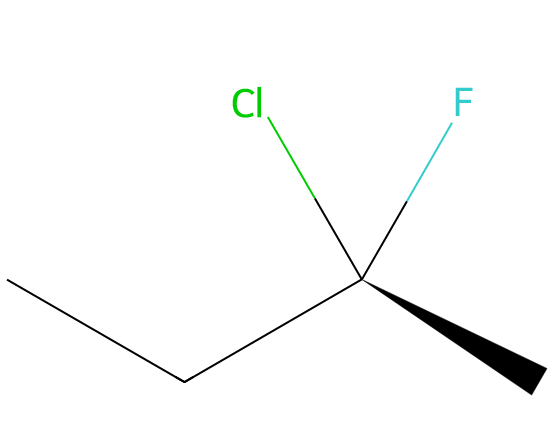

The RDKit needs to be able to use the 2D atomic coordinates here along with the bond wedging information to figure out what the rotation direction at the chiral center should be.

The previous implementation was complex and somewhat fragile at its core (years of patching and improvements made it work).

The new implementation shifts atoms at the end of wedged bonds a bit above the plane and atoms at the end of dashed bonds a bit below the plane and then applies the relatively straightforward code for extracting the stereo of 3D structures.

Thanks to Tad Hurst (at CDD) for the conversation which led me to realize that this approach was both possible and much simpler.

### A detail
(v2024.03.1)

The pseudo-3D perception strategy breaks down for T-shaped molecules (or, in general, molecules where the two non-wedged bonds are co-linear):
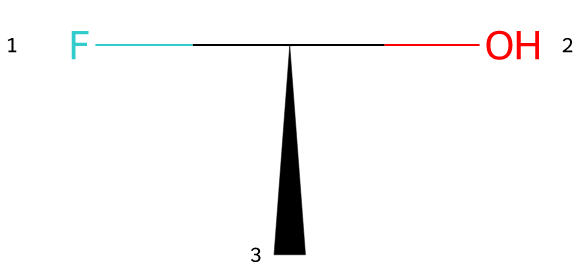

We resolve this by assuming that the "missing" atom (the H) is on the "other side" of the colinear bonds from the wedged atom:

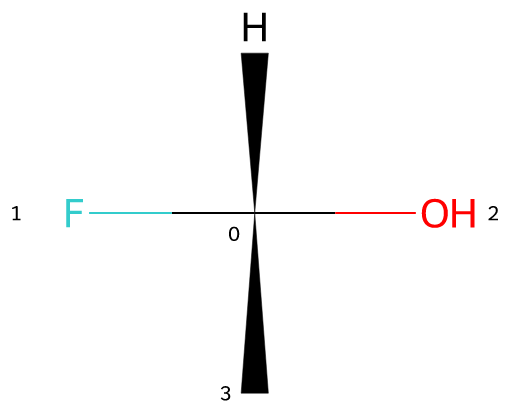

## "New" stereo perception code

This isn't actually particularly new, the original version was in the 2020.09.1 release, but I want to call attention to it now because using the new code will become the default in a future release and this may require some adjustments in your code.

We have not made the new code the default yet because there are still some changes in behavior that we have to either resolve or document.

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2025.03.6


Let's start with one of the more straightforward examples where the new code demonstrates its value:

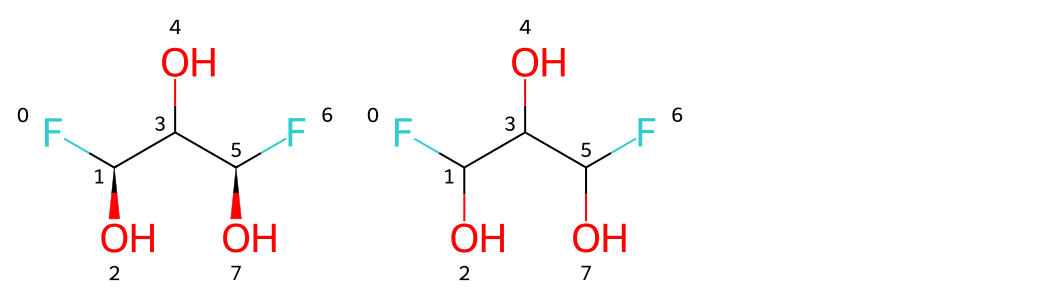

In [38]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = (350,300)

m1 = Chem.MolFromSmiles('F[C@H](O)C(O)[C@@H](F)O')
m2 = Chem.MolFromSmiles('F[CH](O)C(O)[CH](F)O')
Draw.MolsToGridImage([m1,m2],subImgSize=(350,300))

> Aside: in all of the examples here, we are copying the molecule before calling `Chem.FindMolChiralCenters()` because it caches some values on the molecule which can obscure the differences between the algorithms

In [39]:
Chem.FindMolChiralCenters(Chem.Mol(m1),includeUnassigned=True,useLegacyImplementation=True)

[(1, 'S'), (3, '?'), (5, 'R')]

In [40]:
Chem.FindMolChiralCenters(Chem.Mol(m2),includeUnassigned=True,useLegacyImplementation=True)

[(1, '?'), (5, '?')]

That is clearly wrong, but if we disable the legacy implementation then everything is fine:

In [41]:
Chem.FindMolChiralCenters(Chem.Mol(m1),includeUnassigned=True,useLegacyImplementation=False)

[(1, 'S'), (3, '?'), (5, 'R')]

In [42]:
Chem.FindMolChiralCenters(Chem.Mol(m2),includeUnassigned=True,useLegacyImplementation=False)

[(1, '?'), (3, '?'), (5, '?')]

The default for `FindMolChiralCenters()` is to use the old code:

In [43]:
Chem.FindMolChiralCenters(Chem.Mol(m2),includeUnassigned=True)

[(1, '?'), (5, '?')]

This is, of course, not the whole story. What's more interesting is what happens when the molecule is parsed and the initial stereochemistry assignment is done.

To demonstrate this, I'll also show how to turn the legacy code on (the default) or off via a function in the `rdkit.Chem` module.

Here's a molecule that causes problems for the old algorithm.

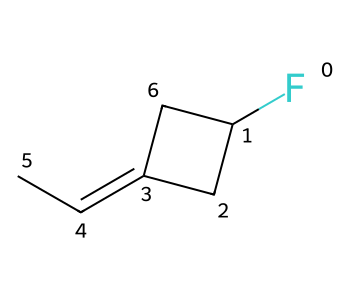

In [44]:
Chem.SetUseLegacyStereoPerception(True)  # < make sure we're using legacy stereo perception
m3 = Chem.MolFromSmiles('F[C@H]1C/C(=C/C)C1')
m3

Here atom 1 actually is a chiral center and the double bond is a stereo bond, but the old algorithm can't handle this:

In [45]:
m3.Debug()

Atoms:
	0 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 3 imp: 1 hyb: SP3
	2 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	3 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	6 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 2->3 order: 1
	3 3->4 order: 2
	4 4->5 order: 1
	5 3->6 order: 1
	6 6->1 order: 1


The new algorithm, on the other hand, is fine:

In [46]:
Chem.SetUseLegacyStereoPerception(False) # < make sure we're using The new stereo code
m3 = Chem.MolFromSmiles('F[C@H]1C/C(=C/C)C1')
m3.Debug()

Atoms:
	0 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CW nbrs:[0 2 6]
	2 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	3 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	6 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 2->3 order: 1 dir: /
	3 3->4 order: 2 stereo: TRANS ats: (2 5)
	4 4->5 order: 1 dir: /
	5 3->6 order: 1
	6 6->1 order: 1


Note that when the the global `useLegacyStereoPerception` value is False, `Chem.FindMolChiralCenters()` will use the new code by default:

The new code is not already the default because there are some behavior changes which affect some end-user code. Specifically:

1. Chiral atoms no longer have a property `_CIPCode` with their pseudo-CIP labels (but you can get these)
2. Double bonds will be labelled `CIS` or `TRANS` instead of the pseudo-CIP values `E` and `Z`
3. Ring stereochemistry is handled differently
4. We haven't done enough testing of how it fits in with the full RDKit.

I use the phrase "pseudo-CIP" here because the labels that the legacy code assigns are only correct CIP labels in the simplest of cases. For anything complicated (and check out this publication to see how complicated it can get: https://pubs.acs.org/doi/10.1021/acs.jcim.8b00324) the results are consistent, but likely incorrect. 

> For those who are interested, the pseudo-CIP algorithm that the legacy code uses is described in an article from Paul Labute that's unfortunately only still available from the wayback machine: https://web.archive.org/web/20030920051139/http://www.chemcomp.com/Journal_of_CCG/Articles/chiral.html



Let's look at these differences:

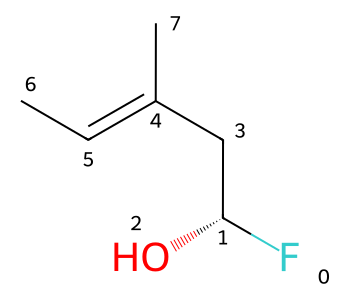

In [47]:
Chem.SetUseLegacyStereoPerception(True) # < make sure we're using The new stereo code
m4_old = Chem.MolFromSmiles('F[C@H](O)C/C(=C/C)C')
Chem.SetUseLegacyStereoPerception(False) # < make sure we're using The new stereo code
m4_new = Chem.MolFromSmiles('F[C@H](O)C/C(=C/C)C')

m4_old

In [48]:
print('atom props:')
print(m4_old.GetAtomWithIdx(1).GetPropsAsDict())
print(m4_new.GetBondWithIdx(1).GetPropsAsDict())

atom props:
{'__computedProps': <rdkit.rdBase._vectclass std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > object at 0x0000022D1A096440>, '_CIPRank': 5, '_ChiralityPossible': 1, '_CIPCode': 'S'}
{}


In [49]:
print('bond stereo:', m4_old.GetBondWithIdx(4).GetStereo(),m4_new.GetBondWithIdx(4).GetStereo())

bond stereo: STEREOE STEREOTRANS


If you need CIP labels for atoms and bonds, use the CIP labelling code, this assigns CIP labels that should be correct:

In [50]:
from rdkit.Chem import rdCIPLabeler
rdCIPLabeler.AssignCIPLabels(m4_new)
print('atom:',m4_new.GetAtomWithIdx(1).GetPropsAsDict())
print('bond:',m4_new.GetBondWithIdx(4).GetPropsAsDict())

atom: {'__computedProps': <rdkit.rdBase._vectclass std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > object at 0x0000022D1A096D40>, '_chiralAtomRank': 7, '_ChiralityPossible': 1, '_CIPCode': 'S'}
bond: {'_CIPCode': 'E'}


If you just want something to rank the atoms in a molecule a way that takes stereochemistry into account, you can do that by getting the canonical atom ranking without tie breaking, this is *considerably* faster than calculating CIP ranks:

In [52]:
list(Chem.CanonicalRankAtoms(m4_new,breakTies=False))

[3, 7, 2, 5, 6, 4, 0, 1]

Further illustration of the CIP stereo labels:

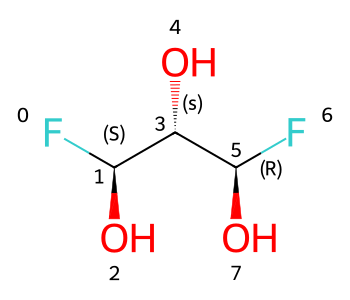

In [53]:
m5 = Chem.MolFromSmiles('F[C@H](O)[C@H](O)[C@@H](F)O')
rdCIPLabeler.AssignCIPLabels(m5)

IPythonConsole.drawOptions.addStereoAnnotation = True
m5

In [54]:
IPythonConsole.drawOptions.addStereoAnnotation = False

I will be blogging more on this topic in the upcoming months

In [55]:
Chem.SetUseLegacyStereoPerception(True)

## Atropisomer support
(2024.03.1)

Developer: Tad Hurst


Rotationally hindered single bonds that give rise to chirality:

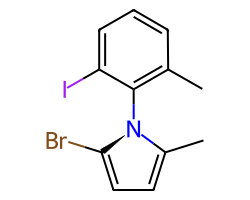

No attempt is made to determine whether or not rotation is actually hindered; if you specify a bond as atropisomeric and it matches the requirements then it will be considered atropisomeric.

Requirements:

- There must be a dashed or wedged bond on one side of the bond. The direction of the wedge is ignored if there are 3D coordinates.
- The bond must be a single bond between SP2 hybridized atoms.
- The neighboring bonds must be single, double or aromatic. 
- If there are two groups on either end, those groups must be different as per CIP rules. 
- The current implementation requires atomic coordinates except for in certain cases.

Atropisomers are currently parsed from, and written to, Mol, CDXML, MRV, and CXSmiles


This is work in progress and we'll continue adding functionality.

For more information:
https://rdkit.org/docs/RDKit_Book.html#atropisomeric-bonds


In [55]:
IPythonConsole.molSize = 350,300

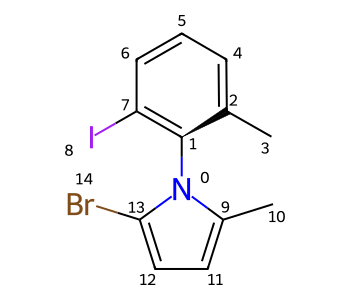

In [56]:
IPythonConsole.drawOptions.addAtomIndices = True
m = Chem.MolFromSmiles('N1(C2C(C)=CC=CC=2I)C(C)=CC=C1Br |wU:1.1,(16.58,-10.58,;16.58,-9.58,;17.45,-9.08,;18.31,-9.57,;17.44,-8.08,;16.58,-7.58,;15.71,-8.08,;15.71,-9.08,;14.84,-9.58,;17.38,-11.17,;18.34,-10.87,;17.08,-12.12,;16.07,-12.12,;15.77,-11.17,;14.81,-10.87,)|')
m

In [57]:
m.Debug()

Atoms:
	0 7 N chg: 0  deg: 3 exp: 3 imp: 0 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	6 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	7 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	8 53 I chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	9 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	10 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	11 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	12 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	13 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	14 35 Br chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1 stereo: CCW bonds: (8 14 1 15) conj?: 1
	1 1->2 order: a dir: wedge conj?: 1 aromatic?: 1
	2 2->3 order: 1
	3 2->4 order: a conj?: 1 aromatic?: 1
	4 4->5 order: a conj?: 1 aromatic?: 1
	5

Correct CIP assignment is done:

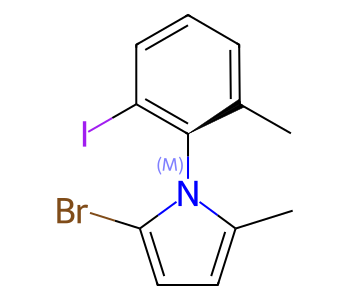

In [6]:
from rdkit.Chem import rdCIPLabeler
rdCIPLabeler.AssignCIPLabels(m)
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True

m

The information is used in conformer generation:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

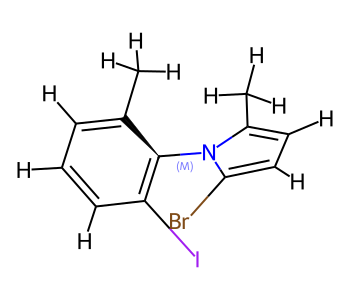

In [7]:
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f

mh = Chem.AddHs(m)
rdDistGeom.EmbedMolecule(mh,ps)
mh

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

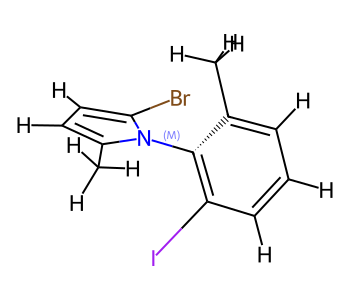

In [61]:
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d+4
ps.enforceChirality = False

mh2 = Chem.AddHs(m)
rdDistGeom.EmbedMolecule(mh2,ps)
mh2

### The representation

Here's the molecule with bond indices shown:
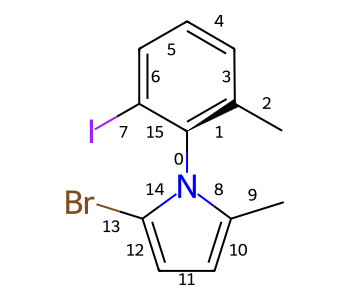

Here's what the output from `mol.Debug()` shows:
> `0 0->1 order: 1 stereo: CCW bonds: (8 14 1 15) conj?: 1`

This tells us that when looking down bond 0, i.e. from atom 0 (the N) to atom 1 (the C), the rotation between bond 8 (the first bond on atom 0) and bond 1 (the first bond on atom 1) is counter-clockwise.


### Perception of atropisomers from 3D

Atropisomeric stereo is only assigned if there is wedged bond on one side of the atropisomeric bond. The nature of the wedging itself is ignored: the 3D coordinates are used to derive the atropisomeric assignment

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

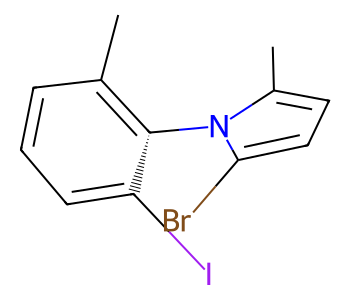

In [8]:
m = Chem.MolFromMolBlock('''
     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 15 16 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N 0.820728 -0.340013 0.413910 0
M  V30 2 C -0.505633 -0.463154 -0.098058 0
M  V30 3 C -1.435394 0.542219 0.079201 0
M  V30 4 C -1.107937 1.782858 0.799883 0
M  V30 5 C -2.727100 0.393180 -0.433634 0
M  V30 6 C -2.965917 -0.793250 -1.097542 0
M  V30 7 C -2.085065 -1.834330 -1.308981 0
M  V30 8 C -0.816423 -1.635282 -0.779440 0
M  V30 9 I 0.622228 -3.161616 -1.039338 0
M  V30 10 C 1.866434 0.341279 -0.034489 0
M  V30 11 C 1.844110 1.176490 -1.264158 0
M  V30 12 C 2.919280 0.145435 0.800063 0
M  V30 13 C 2.513420 -0.705489 1.829463 0
M  V30 14 C 1.183042 -0.988630 1.548767 0
M  V30 15 Br 0.194117 -2.139132 2.711021 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 1 3 5
M  V30 5 2 5 6
M  V30 6 1 6 7
M  V30 7 2 7 8
M  V30 8 1 8 9
M  V30 9 1 1 10
M  V30 10 1 10 11
M  V30 11 2 10 12
M  V30 12 1 12 13
M  V30 13 2 13 14
M  V30 14 1 14 15
M  V30 15 1 1 14
M  V30 16 1 2 8 CFG=3
M  V30 END BOND
M  V30 END CTAB
M  END''')
m

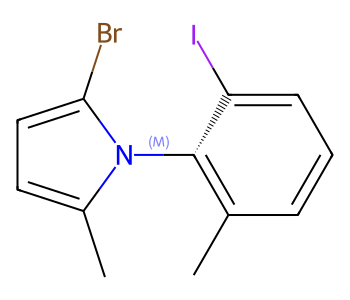

In [9]:
IPythonConsole.drawOptions.useMolBlockWedging = True
m2 = Chem.Mol(m)
m2.RemoveAllConformers()
rdCIPLabeler.AssignCIPLabels(m2)
m2

If the wedged bond is not present in the mol block, then the atropisomeric bond will not be perceived:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

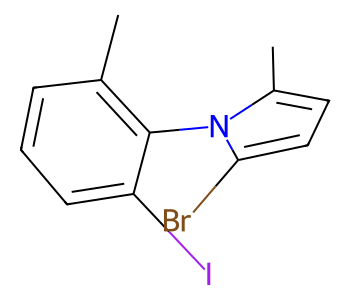

In [10]:
m_nowedge = Chem.MolFromMolBlock('''
     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 15 16 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N 0.820728 -0.340013 0.413910 0
M  V30 2 C -0.505633 -0.463154 -0.098058 0
M  V30 3 C -1.435394 0.542219 0.079201 0
M  V30 4 C -1.107937 1.782858 0.799883 0
M  V30 5 C -2.727100 0.393180 -0.433634 0
M  V30 6 C -2.965917 -0.793250 -1.097542 0
M  V30 7 C -2.085065 -1.834330 -1.308981 0
M  V30 8 C -0.816423 -1.635282 -0.779440 0
M  V30 9 I 0.622228 -3.161616 -1.039338 0
M  V30 10 C 1.866434 0.341279 -0.034489 0
M  V30 11 C 1.844110 1.176490 -1.264158 0
M  V30 12 C 2.919280 0.145435 0.800063 0
M  V30 13 C 2.513420 -0.705489 1.829463 0
M  V30 14 C 1.183042 -0.988630 1.548767 0
M  V30 15 Br 0.194117 -2.139132 2.711021 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 1 3 5
M  V30 5 2 5 6
M  V30 6 1 6 7
M  V30 7 2 7 8
M  V30 8 1 8 9
M  V30 9 1 1 10
M  V30 10 1 10 11
M  V30 11 2 10 12
M  V30 12 1 12 13
M  V30 13 2 13 14
M  V30 14 1 14 15
M  V30 15 1 1 14
M  V30 16 1 2 8
M  V30 END BOND
M  V30 END CTAB
M  END''')
m_nowedge

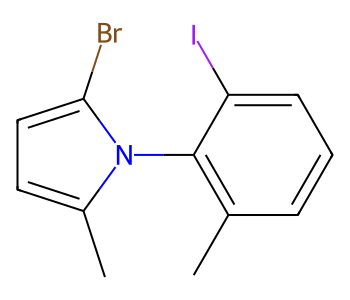

In [11]:
IPythonConsole.drawOptions.useMolBlockWedging = True
m2 = Chem.Mol(m_nowedge)
m2.RemoveAllConformers()
rdCIPLabeler.AssignCIPLabels(m2)
m2

In [12]:
IPythonConsole.drawOptions.useMolBlockWedging = False

### Atropisomers without a conformer

Generally you need a conformer (2D or 3D) for atropisomerism to be perceived, but we adopt a convention to allow expressing atropisomers in CXSMILES without providing coordinates:

> The atropisomeric bond’s stereochemistry is CCW when the bond to the lowest-numbered neighbor of the start atom is wedged. It's CW if the bond is dashed.

For example, if this molecule were provided with the specified wedging but with no coordinates, the atropisomeric bond between atoms 7 and 8 would be CCW:
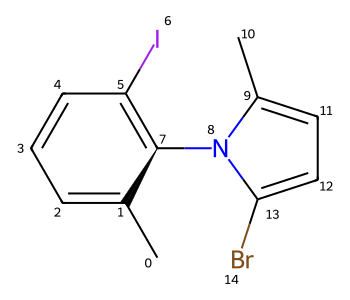

Let's look at that molecule and what Debug shows.

Start by drawing it with the bond IDs:

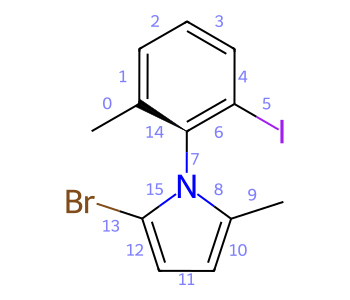

In [67]:
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addBondIndices = True

IPythonConsole.drawOptions.useMolBlockWedging = True
m = Chem.MolFromSmiles('CC1=CC=CC(I)=C1N1C(C)=CC=C1Br |wU:7.7|')
m

In [68]:
m.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	6 53 I chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	8 7 N chg: 0  deg: 3 exp: 3 imp: 0 hyb: SP2 arom?: 1
	9 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	10 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	11 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	12 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	13 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	14 35 Br chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: a conj?: 1 aromatic?: 1
	2 2->3 order: a conj?: 1 aromatic?: 1
	3 3->4 order: a conj?: 1 aromatic?: 1
	4 4->5 order: a conj?: 1 aromatic?: 1
	5 5->6 order: 1
	6 5->7 order:

And if we have a dashed bond, we get CW:

STEREOATROPCW


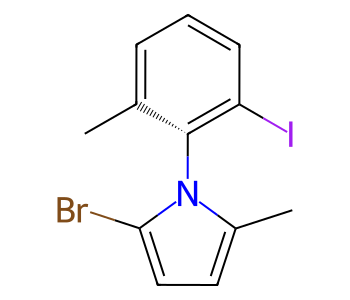

In [69]:
IPythonConsole.drawOptions.addBondIndices = False
m = Chem.MolFromSmiles('CC1=CC=CC(I)=C1N1C(C)=CC=C1Br |wD:7.7|')
print(m.GetBondBetweenAtoms(7,8).GetStereo())
m

In [70]:
IPythonConsole.drawOptions.useMolBlockWedging = False

# MinimalLib improvements
(ongoing)

These affect the JavaScript wrappers as well as the CFFI interface

Paolo is going to talk more about this



# PostgreSQL Cartridge improvements
(ongoing)



# New Features


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2025.03.6


## Improved output from mol.Debug()
2024.03.1


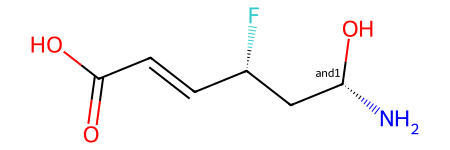

In [2]:
m = Chem.MolFromSmiles('OC(=O)/C=C/[C@H](F)C[C@H](O)N |&1:8|')
m

In [3]:
m.Debug()

Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP2
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: SP2
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
	6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	8 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[7 9 10]
	9 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP3
	10 7 N chg: 0  deg: 1 exp: 1 imp: 2 hyb: SP3
Bonds:
	0 0->1 order: 1 conj?: 1
	1 1->2 order: 2 conj?: 1
	2 1->3 order: 1 dir: / conj?: 1
	3 3->4 order: 2 stereo: E ats: (1 5) conj?: 1
	4 4->5 order: 1 dir: /
	5 5->6 order: 1
	6 5->7 order: 1
	7 7->8 order: 1
	8 8->9 order: 1
	9 8->10 order: 1
Stereo Groups:
	0 AND rId: 1 wId: 0 atoms: { 8 }


What this looked like before:

```
In [3]: m.Debug()
Atoms:
        0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: 3 arom?: 0 chi: 0
        1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 3 arom?: 0 chi: 0
        2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: 3 arom?: 0 chi: 0
        3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
        4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
        5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 4 arom?: 0 chi: 2
        6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: 4 arom?: 0 chi: 0
        7 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: 4 arom?: 0 chi: 0
        8 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 4 arom?: 0 chi: 2
        9 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: 4 arom?: 0 chi: 0
        10 7 N chg: 0  deg: 1 exp: 1 imp: 2 hyb: 4 arom?: 0 chi: 0
Bonds:
        0 0->1 order: 1 conj?: 1 aromatic?: 0
        1 1->2 order: 2 conj?: 1 aromatic?: 0
        2 1->3 order: 1 dir: 4 conj?: 1 aromatic?: 0
        3 3->4 order: 2 stereo: 3 stereoAts: (1 5) conj?: 1 aromatic?: 0
        4 4->5 order: 1 dir: 4 conj?: 0 aromatic?: 0
        5 5->6 order: 1 conj?: 0 aromatic?: 0
        6 5->7 order: 1 conj?: 0 aromatic?: 0
        7 7->8 order: 1 conj?: 0 aromatic?: 0
        8 8->9 order: 1 conj?: 0 aromatic?: 0
        9 8->10 order: 1 conj?: 0 aromatic?: 0
Stereo Groups:
        0 AND rId: 1 wRd: 0 atoms: { 8 }
```

## Change to the way valences are calculated for charged atoms
v2024.09.1

The RDKit used to use some complex (byzantine?) logic for figuring out what valences were allowed for charged atoms. The new approach draws on the idea of isoelectronic species and is very simple. Here are some examples:
- `N+` is equivalent to `C`, so it accepts a valence of 4 (the allowed valence of C)
- `N-` is equivalent to `O`, so it accepts a valence of 2 (the allowed valence of O)
- `P-` is equivalent to `S`, so it accepts valences of 2, 4, or 6 (the allowed valences of S)

Additionally, some chemically unreasonable valences that were previously accepted have been removed. These are:
- Al 6
- Si 6
- P 7
- As 7
- Sb 7
- Bi 7

This should not affect most code, but it's good to understand what is going on in case you encounter any strangeness.

## Jupyter integration improvements

### IPythonConsole drawMols3D

(2024.09.4)

This is a convenience function to display multiple molecules in the 3D viewer.

In [106]:
ms = [x for x in Chem.SDMolSupplier('./data/aligned_mols.sdf',removeHs=False) if x is not None]
IPythonConsole.drawMols3D(ms)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [108]:
IPythonConsole.drawMols3D(ms,removeHs=True,colors=('redCarbon','blueCarbon'))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Improvements to GetBestRMS

In [6]:
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = 250,250

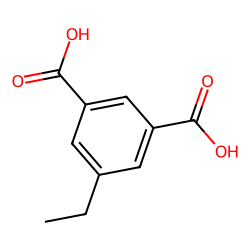

In [7]:
m = Chem.MolFromSmiles('CCc1cc(C(=O)O)cc(C(=O)O)c1')
m

In [8]:
from rdkit.Chem import rdDistGeom

mh = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f
cids = rdDistGeom.EmbedMultipleConfs(mh,100,ps)

In [9]:
m1 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[0]))
m2 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[1]))

IPythonConsole.drawMols3D([m1,m2])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
m1 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[0]))
m2 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[1]))
from rdkit.Chem import rdMolAlign
print(rdMolAlign.GetBestRMS(m1,m2,))
IPythonConsole.drawMols3D([m1,m2])

0.08004265662686423


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Above the carboxyl groups were treated symmetrically. This was added in v2022.09.1 as the default. It can be turned off:

In [12]:
m1 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[0]))
m2 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[1]))
from rdkit.Chem import rdMolAlign
print(rdMolAlign.GetBestRMS(m1,m2,symmetrizeConjugatedTerminalGroups=False))
IPythonConsole.drawMols3D([m1,m2])

0.8596423027642035


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

This is what used to be required to get the full RMSD matrix between the conformers:

In [14]:
def alignAllConfs(m,cids):
    res = []
    for i in range(len(cids)):
        for j in range(i):
            res.append(rdMolAlign.GetBestRMS(m,m,prbId=cids[j],refId=cids[i]))
    return res

In [15]:
m_noh = Chem.RemoveHs(mh)
rmsds = alignAllConfs(m_noh,cids)
print(len(rmsds))
print(rmsds[:5])

4950
[0.08004265662686423, 0.08340803893444163, 0.08506260318224715, 0.06351494135402233, 0.07600462976951448]


A convenience function `GetAllConformerBestRMS()` was added in v2023.09.3

In [16]:
m_noh = Chem.RemoveHs(mh)
rmsds = rdMolAlign.GetAllConformerBestRMS(m_noh)
print(len(rmsds))
print(rmsds[:5])

4950
(0.08004265662685156, 0.08340803893441728, 0.08506260318229487, 0.06351494137752306, 0.07600462976947442)


The new function only has to do the substructure matching once and has less Python/C++ overhead, so it's a lot faster:

In [19]:
m_noh = Chem.RemoveHs(mh)
%timeit rmsds = alignAllConfs(m_noh,cids)

444 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
m_noh = Chem.RemoveHs(mh)
%timeit rmsds = rdMolAlign.GetAllConformerBestRMS(m_noh)

85.9 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It can also use multiple threads simultaneously:

In [21]:
m_noh = Chem.RemoveHs(mh)
%timeit rmsds = rdMolAlign.GetAllConformerBestRMS(m_noh,numThreads=4)

32.2 ms ± 546 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Conformer generation improvements

### Optional sequential random-number seeds in conformer generator
(2023.09)

This lets you generate sets of conformers for a molecule using multiple processes in an easily reproducible manner.

In [22]:
from rdkit.Chem import rdDistGeom
ps = rdDistGeom.ETKDGv3()
ps.enableSequentialRandomSeeds = True
ps.randomSeed = 0xf00d

vemurafenib = Chem.MolFromSmiles('CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4')
mol = Chem.AddHs(vemurafenib)

mcp1 = Chem.Mol(mol)
rdDistGeom.EmbedMultipleConfs(mcp1,100,ps)

mcp2 = Chem.Mol(mol)
rdDistGeom.EmbedMultipleConfs(mcp2,50,ps)

ps.randomSeed += 50
mcp3 = Chem.Mol(mol)
rdDistGeom.EmbedMultipleConfs(mcp3,50,ps)

ps1 = mcp1.GetConformer(0).GetPositions()
ps2 = mcp2.GetConformer(0).GetPositions()
print(ps1[:3])
print(ps2[:3])

print('-------------')
ps1 = mcp1.GetConformer(50).GetPositions()
ps2 = mcp3.GetConformer(0).GetPositions()
print(ps1[:3])
print(ps2[:3])



[[-7.94397016 -1.84689478 -0.43546578]
 [-7.68400631 -0.3693571  -0.4371842 ]
 [-6.26281749 -0.03994927 -0.91545107]]
[[-7.94397016 -1.84689478 -0.43546578]
 [-7.68400631 -0.3693571  -0.4371842 ]
 [-6.26281749 -0.03994927 -0.91545107]]
-------------
[[ 5.68182957 -1.69544258 -1.60970307]
 [ 5.40553601 -0.3357572  -0.99393367]
 [ 5.88647385 -0.37508438  0.45850864]]
[[ 5.68182957 -1.69544258 -1.60970307]
 [ 5.40553601 -0.3357572  -0.99393367]
 [ 5.88647385 -0.37508438  0.45850864]]


### Performance improvements:
ongoing

(Contributors Nikitas Rontsis, Niels Maeder)

Niels will say more about some things that are coming.

One quick demo from my laptop. This is using 38 molecules.

Runtime with v2023.09.1:
```
In [5]: ps = rdDistGeom.ETKDGv3()

In [6]: ps.randomSeed = 0xa100f

In [7]: ps.numThreads = 2

In [8]: %timeit [rdDistGeom.EmbedMultipleConfs(m,10,ps) for m in ms]
7.41 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```
and with v2025.03.6:
```
In [8]: %timeit [rdDistGeom.EmbedMultipleConfs(m,10,ps) for m in ms]
5.88 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```
The amount of speedup varies with molecules and options.

As a comparison, here's the runtime using WSL on the same laptop.
With 2023.09.1:
```
6.26 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```
With 2025.03.6:
```
5.18 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

> This performance gap between Windows and Linux is something we've been aware of for a long time and don't really have a handle on.

## Interface to the PubChem shape-based alignment code
(2024.09.1)

**Note* that there's an important bug fix in the 2025.03.6 release. 

In 2024, the PubChem team released [pubchem-align3d](https://github.com/ncbi/pubchem-align3d), an open-source library for doing shape-based alignment of molecules.

We've put an RDKit wrapper around this and added it an optional RDKit feature.

The API here is likely to evolve over the next couple of releases.

Start by reading in a bunch of molecules with 3D structures to align. Take the first molecule as our reference (the thing to align to): 

[07:37:08] Explicit valence for atom # 21 C, 5, is greater than permitted
[07:37:08] ERROR: Could not sanitize molecule ending on line 1352
[07:37:08] ERROR: Explicit valence for atom # 21 C, 5, is greater than permitted


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

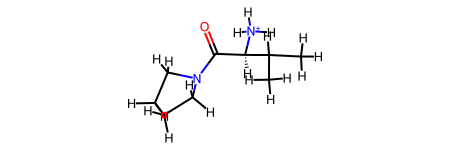

In [19]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

ms = [x for x in Chem.SDMolSupplier('./data/AZ_alignment/P27487.sdf',removeHs=False) if x is not None]
len(ms)

ref = ms.pop(0)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

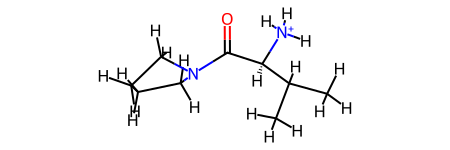

In [26]:
ref

Generate 100 conformers of each of the molecules to align:

In [20]:
ps = rdDistGeom.srETKDGv3()
ps.randomSeed = 0xa100f
ps.numThreads = 8
for m in ms:
    rdDistGeom.EmbedMultipleConfs(m,100,ps)

In [21]:
len(ms)

37

In [22]:
import copy
ms_save = copy.deepcopy(ms)

In [23]:
ms = copy.deepcopy(ms_save)

Look at the two molecules to align, just to see where we are starting.

In [24]:
IPythonConsole.drawMols3D([ref,ms[0]])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Do an alignment and look at the results.


In [25]:
from rdkit.Chem import rdShapeAlign
from rdkit.Chem import rdMolTransforms

# at the moment (v2025.03.6), we recommend moving molecules into the principle axis frame before
# calling the shape alignment code. We'll handle this automatically in a future release (likely 2025.09.1)
rdMolTransforms.CanonicalizeMol(ref)
rdMolTransforms.CanonicalizeMol(ms[0])

tpl = rdShapeAlign.AlignMol(ref,ms[0], opt_param=0.5)
print(tpl)


IPythonConsole.drawMols3D([ref,ms[0]])

(0.45938369494202697, 0.05548822000824501)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The two scores are: shape Tanimoto, "color" (=chemical feature) Tanimoto

The default chemical features used are from the "Gobbi" pharmacophore definitions used elsewhere in the RDKit:
- Donor
- Acceptor
- Rings
- Basic
- Acidic

If the molecule has a property `PUBCHEM_PHARMACOPHORE_FEATURES` that follows the formatting used by PubChem, these features will be used instead of the RDKit definitions:
```
>  <PUBCHEM_PHARMACOPHORE_FEATURES>  (1) 
5
1 2 acceptor
1 3 acceptor
1 4 acceptor
3 2 3 11 anion
6 5 6 7 8 9 10 rings
```
The supported types are:
- acceptor
- anion
- cation
- donor
- hydrophobe
- rings

At the moment (v2025.03.6) if you want to define your own features, you need to "hijack" this mechanism and create your own property string.


Find the conformer from each molecule that provides the highest "color" score and see how long that takes.

In [27]:
import time

t1 = time.time()
refShape = rdShapeAlign.PrepareConformer(ref)

nAligns = 0
bestScores = []
for m in ms:
    rdMolTransforms.CanonicalizeMol(m)
    best = -1e8
    bestConf = -1
    for conf in m.GetConformers():
        nAligns += 1
        shapeTani,colorTani = rdShapeAlign.AlignMol(refShape,m,probeConfId=conf.GetId(),opt_param=0.5)
        if colorTani > best:
            best = colorTani
            bestConf = conf.GetId()
    bestScores.append((best,bestConf))
t2 = time.time()
print(f'{t2-t1:.2f} seconds for {nAligns} alignments, {(t2-t1)/nAligns:.2g}s per alignment')

4.55 seconds for 3700 alignments, 0.0012s per alignment


Look at the best alignment for one of the molecules:

In [28]:
whichMol = 1
bestConf = bestScores[whichMol][1]

print(bestScores[whichMol])
IPythonConsole.drawMols3D([ref,ms[whichMol]],confIds=[-1, bestConf])


(0.2765137141792468, 8)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Which of the molecules produced the highest score?

In [29]:
order = sorted([(tpl,i) for i,tpl in enumerate(bestScores)],reverse=True)
order[:5]

[((0.41678790112762254, 53), 10),
 ((0.4016958033186934, 44), 14),
 ((0.3365472874348875, 87), 17),
 ((0.3018578472159666, 91), 2),
 ((0.2984470496980833, 48), 13)]

In [30]:
whichMol = 10
bestConf = bestScores[whichMol][1]

print(bestScores[whichMol])
IPythonConsole.drawMols3D([ref,ms[whichMol]],confIds=[-1, bestConf])


(0.41678790112762254, 53)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [105]:
w = Chem.SDWriter('./data/aligned_mols.sdf')
w.write(ref)
w.write(ms[whichMol],confId=bestConf)
w.flush()


## More multi-threading

In [39]:
ms = [x for x in Chem.SDMolSupplier('./data/platinum_dataset_2017_01.sdf')]
len(ms)

4548

### MolStandardize
ongoing, started in v2023.09.3

In [35]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import rdBase


In [40]:
with rdBase.BlockLogs():
    %timeit nms = [Chem.Mol(m) for m in ms]; [rdMolStandardize.Normalize(m) for m in nms]


2.33 s ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
with rdBase.BlockLogs():
    %timeit nms = [Chem.Mol(m) for m in ms]; [rdMolStandardize.NormalizeInPlace(m) for m in nms]

1.95 s ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
with rdBase.BlockLogs():
    %timeit nms = [Chem.Mol(m) for m in ms]; rdMolStandardize.NormalizeInPlace(nms,numThreads=1)

617 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
with rdBase.BlockLogs():
    %timeit nms = [Chem.Mol(m) for m in ms]; rdMolStandardize.NormalizeInPlace(nms,numThreads=4)

314 ms ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There are `InPlace` versions of many of the functions in `rdMolStandardize`:
- `ReionizeInPlace()`
- `CleanupInPlace()`
- `NormalizeInPlace()`
- `RemoveFragmentsInPlace()`
- ~`DisconnectOrganometallicsInPlace()`~ (doesn't currently take `numThreads` argument)
- `TautomerParentInPlace()`
- `FragmentParentInPlace()`
- `StereoParentInPlace()`
- `IsotopeParentInPlace()`
- `ChargeParentInPlace()`
- `SuperParentInPlace()`


### Fingerprint generation
v2023.09.3

In [36]:
from rdkit.Chem import rdFingerprintGenerator
fpg = rdFingerprintGenerator.GetMorganGenerator()

In [37]:
%timeit [fpg.GetFingerprint(m) for m in ms]

249 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There's are new bulk functions to calculate fingerprints for multiple molecules in a single call:

In [38]:
%timeit fpg.GetFingerprints(ms)

239 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
fpg.Get

The functions `GetCountFingerprints()`, `GetSparseFingerprints()`, and `GetSparseCountFingerprints()` are also there

These can also use multiple threads:

In [39]:
%timeit fpg.GetFingerprints(ms,numThreads=4)

62.6 ms ± 124 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### rdMolProcessing
v2024.09.1

Efficiently generating fingerprints for a bunch of molecules without having to load all the molecules into memory at once.

Here's the "standard" way to do it:
```
In [16]: fpg = rdFingerprintGenerator.GetMorganGenerator()

In [19]: %timeit suppl = Chem.SmilesMolSupplier('../Regress/Data/znp.50k.smi');fps = [fpg.GetFingerprint(m) for m in suppl if m is not None]
8.22 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

Here's how it works with the new code:

```
In [27]: opts = rdMolProcessing.SupplierOptions()

In [28]: opts.delimiter = ' '

In [29]: %timeit fps = rdMolProcessing.GetFingerprintsForMolsInFile('../Regress/Data/znp.50k.smi',options=opts)
1.3 s ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

This works for quite large datasets; here's an example of generating fingerprints for the 2.3 million compounds in ChEMBL31:
```
In [44]: t1 = time.time(); fps = rdMolProcessing.GetFingerprintsForMolsInFile('/scratch/Data/ChEMBL/chembl_31.sdf.gz'); t2=time.time(); print(f'{t2-t1:.2f}')
74.72

In [45]: len(fps)
Out[45]: 2304875
```
Notice that I didn't have to do anything special to deal with the compressed input file.

## Synthon space search
(ongoing, first appeard in 2024.09.3)

Developer David Cosgrove, funded by Andy Palmer

There's a [blog post](https://greglandrum.github.io/rdkit-blog/posts/2024-12-03-introducing-synthon-search.html) with more details and Anna is going to talk more about this.

> Note: all timings below were generated on my three-year-old laptop.

In [46]:
from rdkit.Chem import rdSynthonSpaceSearch, rdFingerprintGenerator
import time

In [47]:
spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadDBFile('./Data/2023-05_Freedom_synthons.spc')
print(f"Number of reactions : {spc.GetNumReactions()}")
print(f"Number of products : {spc.GetNumProducts()}")


Number of reactions : 10
Number of products : 9360696185


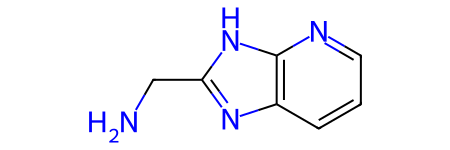

In [48]:
qry = Chem.MolFromSmiles('n1cccc2nc(CN)[nH]c21')
qry

In [49]:
res = spc.SubstructureSearch(qry)
hits = res.GetHitMolecules()

In [50]:
len(hits)

492

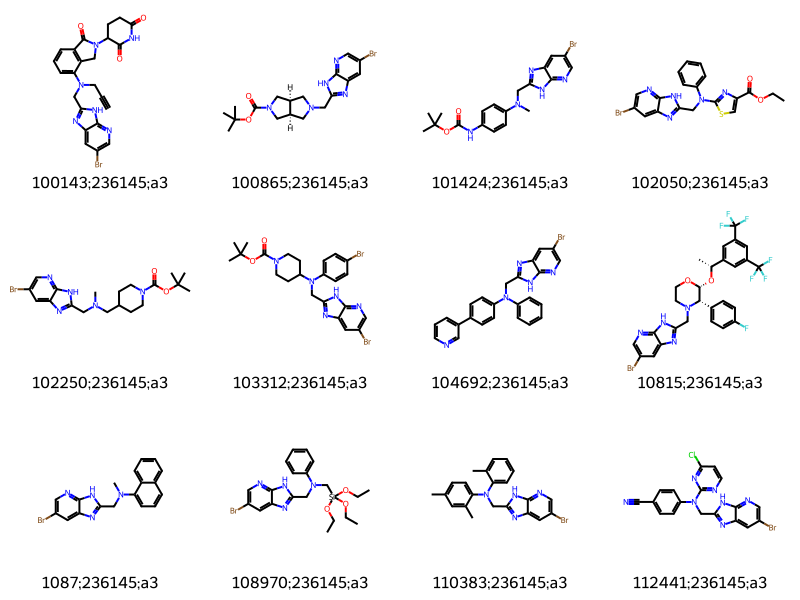

In [144]:
Draw.MolsToGridImage(hits[:12],legends=[x.GetProp('_Name') for x in hits],molsPerRow=4)

In [146]:
%timeit res = spc.SubstructureSearch(qry)

270 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [147]:
%timeit hits = res.GetHitMolecules()

17.8 ms ± 523 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You can also do generalized substructure searches:

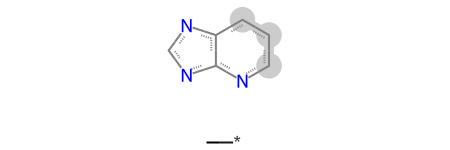

In [52]:
from rdkit.Chem import rdGeneralizedSubstruct
qry = Chem.MolFromSmarts('[#6]-*.c1nc2cccnc2n1 |m:1:5.6.7|')
                    
qry

[09:27:40] Complex queries can be slow.
[09:27:41] Complex queries can be slow.
[09:27:41] Complex queries can be slow.


Number of hits: 1000


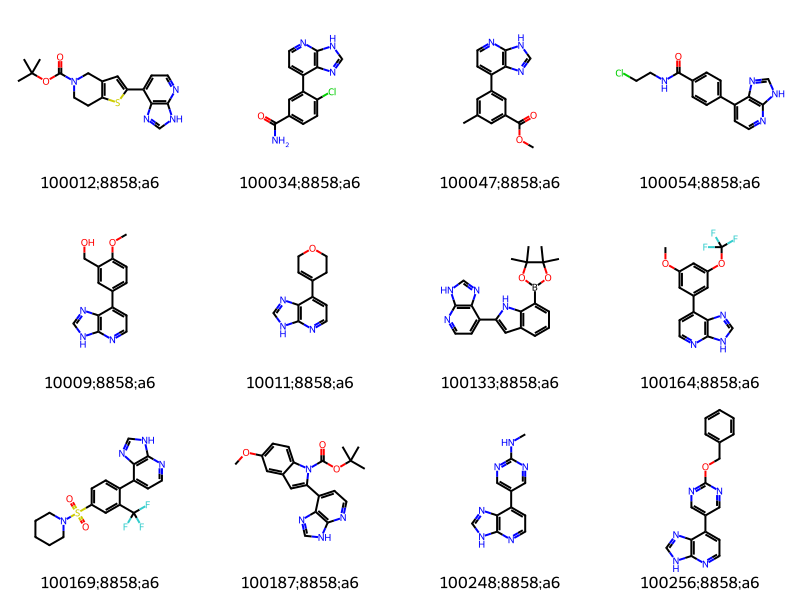

In [53]:
aqps = Chem.AdjustQueryParameters()
aqps.adjustHeavyDegree = True
aqps.adjustHeavyDegreeFlags = Chem.AdjustQueryWhichFlags.ADJUST_IGNORECHAINS

xqry = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry,adjustQueryProperties=True,
                                                     adjustQueryParameters=aqps)
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True

res = spc.SubstructureSearch(xqry,substructMatchParams=params)
hits = res.GetHitMolecules()
print(f'Number of hits: {len(hits)}')
Draw.MolsToGridImage(hits[:12],legends=[x.GetProp('_Name') for x in hits],molsPerRow=4)

In [9]:
from rdkit import rdBase
with rdBase.BlockLogs():
    %timeit spc.SubstructureSearch(xqry,substructMatchParams=params)


1.64 s ± 46.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
ps = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
ps.numThreads = 4
with rdBase.BlockLogs():
    %timeit spc.SubstructureSearch(xqry,substructMatchParams=params, params=ps)


800 ms ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


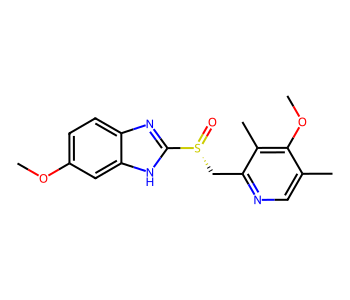

In [11]:
esomeprazole = Chem.MolFromSmiles('COc1ccc2nc([nH]c2c1)[S@](=O)Cc1ncc(C)c(OC)c1C')
esomeprazole

In [12]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
spc.BuildSynthonFingerprints(fpgen)

[09:57:55] Building the fingerprints may take some time.


Number of hits: 5


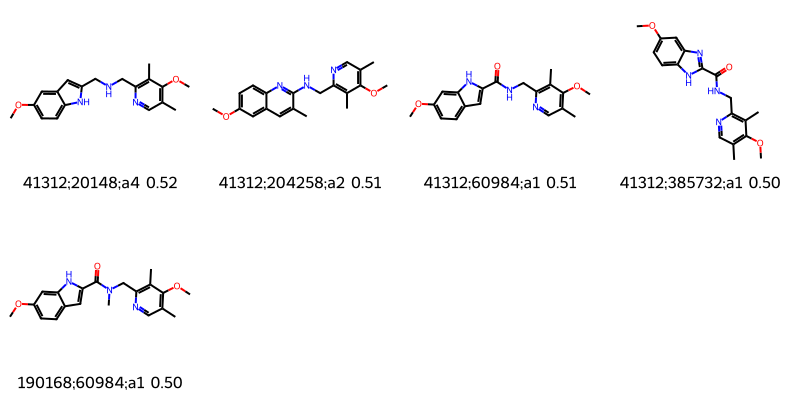

In [207]:
res = spc.FingerprintSearch(esomeprazole,fpgen)
hits = res.GetHitMolecules()
print(f'Number of hits: {len(hits)}')
Draw.MolsToGridImage(hits[:12],
                     legends=[f'{x.GetProp('_Name')} {x.GetDoubleProp('Similarity'):.2f}' for x in hits],
                     molsPerRow=4)

In [197]:
%timeit res = spc.FingerprintSearch(esomeprazole,fpgen)

10.6 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can also speed these searches up 

In [201]:
ps = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
ps.numThreads = 4
%timeit res = spc.FingerprintSearch(esomeprazole,fpgen,params=ps)

3.23 s ± 92.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [208]:
from rdkit.Chem import rdRascalMCES
rascalOpts = rdRascalMCES.RascalOptions()
ps = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
ps.numThreads = 4
ps.maxHits = 10
res = spc.RascalSearch(esomeprazole,rascalOpts,params=ps)
hits = res.GetHitMolecules()
print(f'Number of hits: {len(hits)}')

Number of hits: 10


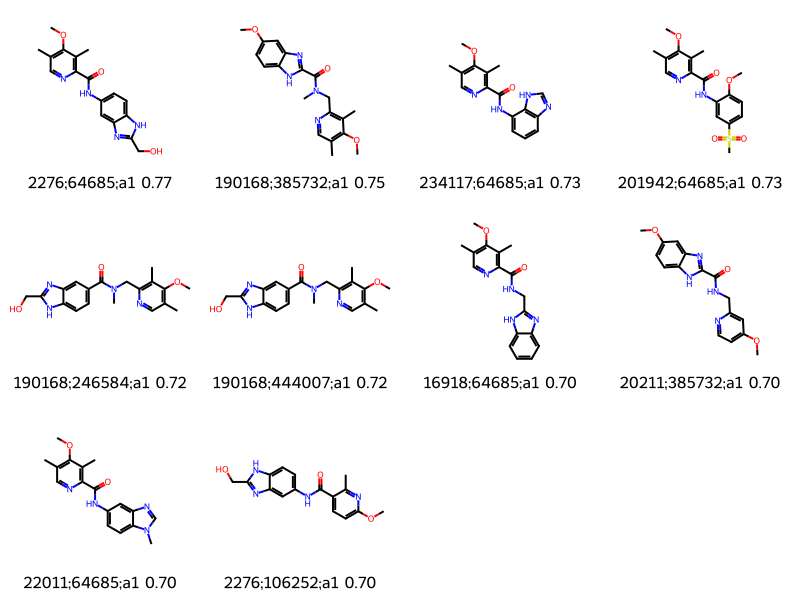

In [209]:
Draw.MolsToGridImage(hits[:12],
                     legends=[f'{x.GetProp('_Name')} {x.GetDoubleProp('Similarity'):.2f}' for x in hits],
                     molsPerRow=4)

These searches take quite a bit longer, but it's still pretty impressive considering that we're searching through almost 9.4 billion compounds.

In [206]:
%timeit spc.RascalSearch(esomeprazole,rascalOpts,params=ps)

7min 21s ± 11.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Rascal MCES implementation
(2023.09)

Developer David Cosgrove, funded by Glysade

The Rascal (Rapid Similarity CALculation) algorithm of Raymond et al. is a rapid way of finding Maximum Common Edge Subgraphs, optimised for chemical structures. It finds the bonds that are in common between 2 structures, rather than the more normal matching atoms. The result is usually, but not always, the same. 

Unlike the rdFMCS approach, Rascal:
- can produce a fragmented MCES if relevant.
- only works on pairs of molecules


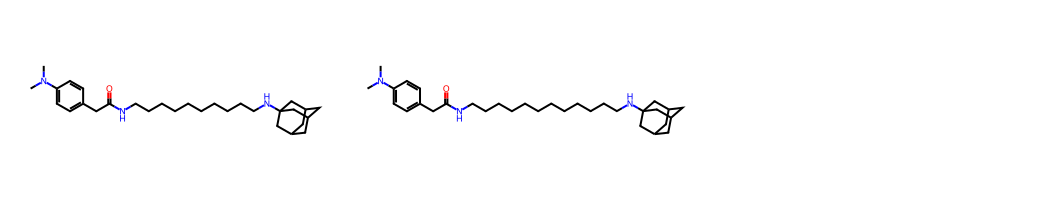

In [13]:
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

from rdkit.Chem import rdRascalMCES

mol1 = Chem.MolFromSmiles('CN(C)c1ccc(CC(=O)NCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1')
mol2 = Chem.MolFromSmiles('CN(C)c1ccc(CC(=O)NCCCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1')
Draw.MolsToGridImage((mol1,mol2),subImgSize=(350,200))

In [14]:
results = rdRascalMCES.FindMCES(mol1, mol2)
res = results[0]
print(f'MCES SMARTS : {res.smartsString}')
print(f'Matching Bonds : {res.bondMatches()}')
print(f'Matching Atoms : {res.atomMatches()}')

MCES SMARTS : CN(-C)-c1:c:c:c(-CC(=O)-NCCCCCCCCCC):c:c:1.NC12CC3CC(-C1)-CC(-C2)-C3
Matching Bonds : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35), (34, 36), (35, 37), (36, 38)]
Matching Atoms : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35)]


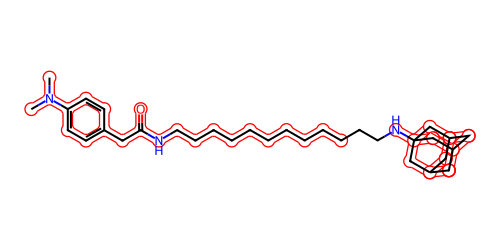

In [15]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def extractHighlights(res):
    bondHighlights1 = {}
    bondHighlights2 = {}
    for bondPair in res.bondMatches():
        bondHighlights1[bondPair[0]] = [(1.0, 0.0, 0.0)]
        bondHighlights2[bondPair[1]] = [(1.0, 0.0, 0.0)]
    atomHighlights1 = {}
    atomHighlights2 = {}
    for atomPair in res.atomMatches():
        atomHighlights1[atomPair[0]] = [(1.0, 0.0, 0.0)]
        atomHighlights2[atomPair[1]] = [(1.0, 0.0, 0.0)]
    return bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2

def drawMCESMatch(mol1, bondHighlights, atomHighlights):    
    d = rdMolDraw2D.MolDraw2DSVG(500, 250)
    d.drawOptions().fillHighlights = False
    d.drawOptions().multiColourHighlightStyle = Draw.MultiColourHighlightStyle.Lasso
    hRads = {}
    hLwMult = {}
    d.DrawMoleculeWithHighlights(mol1, "", atomHighlights, bondHighlights, hRads, hLwMult, -1)
    d.FinishDrawing()
    return d

bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2 = extractHighlights(res)
d = drawMCESMatch(mol2, bondHighlights2, atomHighlights2)
SVG(d.GetDrawingText())


### MCES Clustering

In [16]:
from rdkit import RDConfig
import os
from pathlib import Path
cdk2_file = Path(RDConfig.RDContribDir) / 'Fastcluster' / 'cdk2.smi'
suppl = Chem.SmilesMolSupplier(str(cdk2_file), '\t', 1, 0, False)
mols = [mol for mol in suppl]
print(f'{len(mols)} molecules')
clusters = rdRascalMCES.RascalCluster(mols)
print(clusters)

47 molecules
[[3, 4, 1, 2, 0, 28, 29], [25, 26, 38, 24, 46, 39, 27], [6, 34, 35, 7, 5, 44], [36, 44], [13, 14], [19, 20], [21, 22], [16, 18, 17, 10, 23, 30, 32, 15, 31, 33, 9, 37, 42, 8, 11, 12, 40, 41, 43, 45]]


In [17]:
import ipywidgets as widgets
from ipywidgets import interact,fixed
from IPython.display import SVG,Image

@interact(whichCluster=range(len(clusters)))
def showCluster(whichCluster):
    return Draw.MolsToGridImage([mols[x] for x in clusters[whichCluster]],molsPerRow=4)

interactive(children=(Dropdown(description='whichCluster', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), Output(…

In [18]:
%timeit clusters = rdRascalMCES.RascalCluster(mols)

142 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
clusters = rdRascalMCES.RascalButinaCluster(mols)
print(clusters)

[[25, 26, 38, 24, 27, 46], [6, 34, 5, 35, 44, 7], [4, 3, 1, 2, 0, 28], [22, 21], [20, 19], [14, 13], [45], [43], [42], [41], [40], [39], [37], [36], [33], [32], [31], [30], [29], [23], [18], [17], [16], [15], [12], [11], [10], [9], [8]]


In [20]:
import ipywidgets as widgets
from ipywidgets import interact,fixed
from IPython.display import SVG,Image

@interact(whichCluster=range(len(clusters)))
def showCluster(whichCluster):
    return Draw.MolsToGridImage([mols[x] for x in clusters[whichCluster]],molsPerRow=4)

interactive(children=(Dropdown(description='whichCluster', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

In [22]:
%timeit clusters = rdRascalMCES.RascalButinaCluster(mols)

96.8 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Misc

### Simplifying enhanced stereo

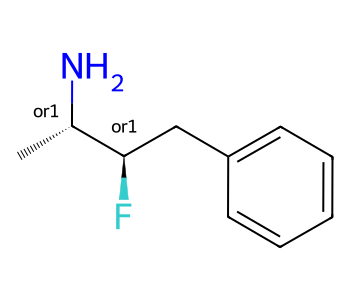

In [82]:
m = Chem.MolFromSmiles('C[C@H](N)[C@@H](Cc1ccccc1)F |o1:1,3|')
m

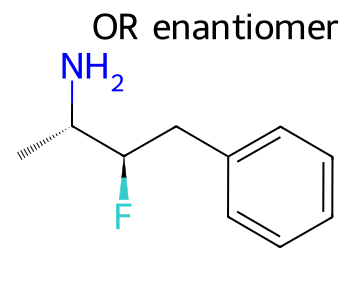

In [89]:
IPythonConsole.ipython_showProperties = False
m2 = Chem.Mol(m)
Chem.SimplifyEnhancedStereo(m2)
m2

This doesn't do anything if you have more than one stereo group.

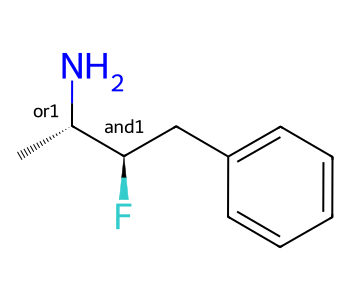

In [90]:
m = Chem.MolFromSmiles('C[C@H](N)[C@@H](Cc1ccccc1)F |o1:1;&2:3|')
m

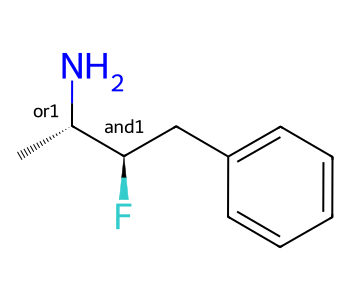

In [91]:
m2 = Chem.Mol(m)
Chem.SimplifyEnhancedStereo(m2)
m2

### Better SMILES and SMARTS error reporting

(2025.03.1)

Developer: Hussein Faara 

In [126]:
Chem.MolFromSmiles('C1CCCC&')

[11:48:35] SMILES Parse Error: syntax error while parsing: C1CCCC&
[11:48:35] SMILES Parse Error: check for mistakes around position 7:
[11:48:35] C1CCCC&
[11:48:35] ~~~~~~^
[11:48:35] SMILES Parse Error: Failed parsing SMILES 'C1CCCC&' for input: 'C1CCCC&'


In [128]:
Chem.MolFromSmiles('C1CC(CC1')

[11:49:14] SMILES Parse Error: extra open parentheses while parsing: C1CC(CC1
[11:49:14] SMILES Parse Error: check for mistakes around position 5:
[11:49:14] C1CC(CC1
[11:49:14] ~~~~^
[11:49:14] SMILES Parse Error: Failed parsing SMILES 'C1CC(CC1' for input: 'C1CC(CC1'


In [130]:
Chem.MolFromSmarts('CC[CX3')

[11:49:46] SMARTS Parse Error: syntax error while parsing: CC[CX3
[11:49:46] SMARTS Parse Error: check for mistakes around position 6:
[11:49:46] CC[CX3
[11:49:46] ~~~~~^
[11:49:46] SMARTS Parse Error: Failed parsing SMARTS 'CC[CX3' for input: 'CC[CX3'


### Sanitizing reaction components
v2023.09.5 

In [39]:
from rdkit.Chem import rdChemReactions

rxn = rdChemReactions.ReactionFromSmarts("C1=CC=CC=C1>CN(=O)=O>C1=CC=CC=N1", useSmiles=True)
rxn.GetReactantTemplate(0).Debug()

Atoms:
	0 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	1 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	2 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	3 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	4 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	5 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
Bonds:
	0 0->1 order: 2
	1 1->2 order: 1
	2 2->3 order: 2
	3 3->4 order: 1
	4 4->5 order: 2
	5 5->0 order: 1


In [40]:
rdChemReactions.SanitizeRxnAsMols(rxn)
rxn.GetReactantTemplate(0).Debug()

Atoms:
	0 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
Bonds:
	0 0->1 order: a conj?: 1 aromatic?: 1
	1 1->2 order: a conj?: 1 aromatic?: 1
	2 2->3 order: a conj?: 1 aromatic?: 1
	3 3->4 order: a conj?: 1 aromatic?: 1
	4 4->5 order: a conj?: 1 aromatic?: 1
	5 5->0 order: a conj?: 1 aromatic?: 1


### Molzip now supports the output of R-group decomposition
v2024.03.1

Developer: Brian Kelley

First a reminder about what molzip does:

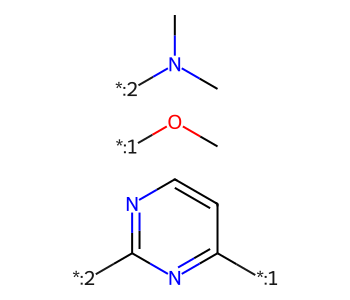

In [41]:
IPythonConsole.molSize = 350,300
from rdkit.Chem import rdRGroupDecomposition
sample = Chem.MolFromSmiles('[*:1]c1nc([*:2])ncc1.CO[*:1].[*:2]N(C)C')
sample


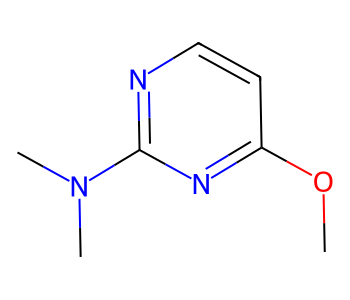

In [42]:
Chem.molzip(sample)

Here's how it works with R-group decomposition:

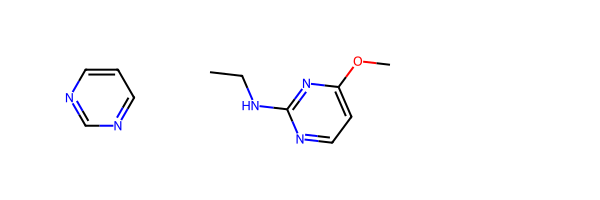

In [43]:
core = Chem.MolFromSmiles('c1ncncc1')
mol = Chem.MolFromSmiles('c1nc(NCC)nc(OC)c1')
Draw.MolsToGridImage([core,mol])

In [44]:
rgd,_ = rdRGroupDecomposition.RGroupDecompose(core,[mol])
rgd[0]

{'Core': <rdkit.Chem.rdchem.Mol at 0x21452e55f50>,
 'R1': <rdkit.Chem.rdchem.Mol at 0x21452e55ee0>,
 'R2': <rdkit.Chem.rdchem.Mol at 0x21452e56b20>}

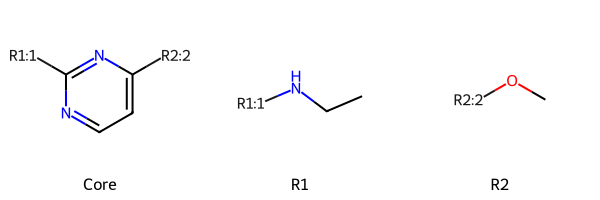

In [45]:
Draw.MolsToGridImage(rgd[0].values(),legends=rgd[0].keys())

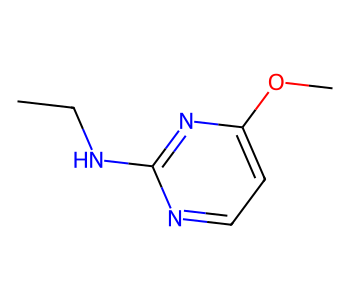

In [46]:
nmol = Chem.molzip(rgd[0])
nmol

This makes it easy to enumerate all compounds covered by the R-groups of a set of compounds

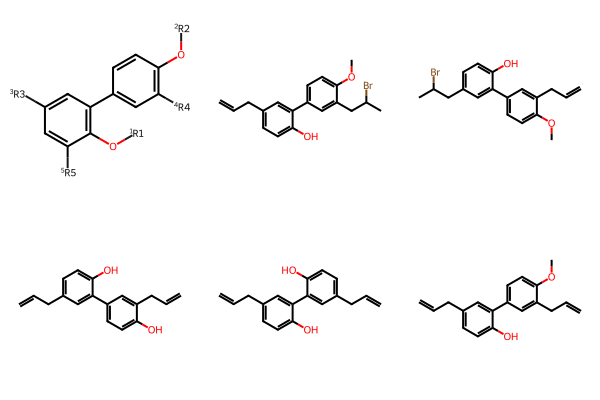

In [47]:
mols = [x for x in Chem.ForwardSDMolSupplier('c:/users/glandrum/RDKit_git/Code/GraphMol/RGroupDecomposition/test_data/jm200186n.excerpt.sdf')]
Draw.MolsToGridImage(mols[:6])

In [48]:
core = mols.pop(0)

In [49]:
rgd,mismatch = rdRGroupDecomposition.RGroupDecompose(core,mols,asRows=False)
print(len(mismatch),'mismatches')
matched_mols = [mols[x] for x in range(len(mols)) if x not in mismatch]
rgd

1 mismatches


[14:09:27] No core matches


{'Core': [<rdkit.Chem.rdchem.Mol at 0x21452e57060>,
 'R2': [<rdkit.Chem.rdchem.Mol at 0x21452b99850>,
 'R3': [<rdkit.Chem.rdchem.Mol at 0x21452b995b0>,
 'R4': [<rdkit.Chem.rdchem.Mol at 0x21452b9b5a0>,
 'R6': [<rdkit.Chem.rdchem.Mol at 0x21452b9b0d0>,
  <rdkit.Chem.rdchem.Mol at 0x21452b9af10>]}

Get the unique entries:

In [50]:
for k in ('Core','R2','R3','R4','R6'):
    seen = set()
    unique = []
    for m in rgd[k]:
        smi = Chem.MolToSmiles(m)
        if smi in seen:
            continue
        unique.append(m)
        seen.add(smi)
    rgd[k] = unique
    print(k,len(seen))

Core 1
R2 2
R3 2
R4 2
R6 2


Form all possible combinations

In [51]:
sets = []
for core in rgd['Core']:
    for r2 in rgd['R2']:
        for r3 in rgd['R3']:
            for r4 in rgd['R4']:
                for r6 in rgd['R6']:
                    sets.append({'Core':core,'R2':r2,'R3':r3,'R4':r4,'R6':r6})

len(sets)

16

Now form the molecules and filter out the ones we've already seen:

starting with 5 original molecules and 16 candidates.
11


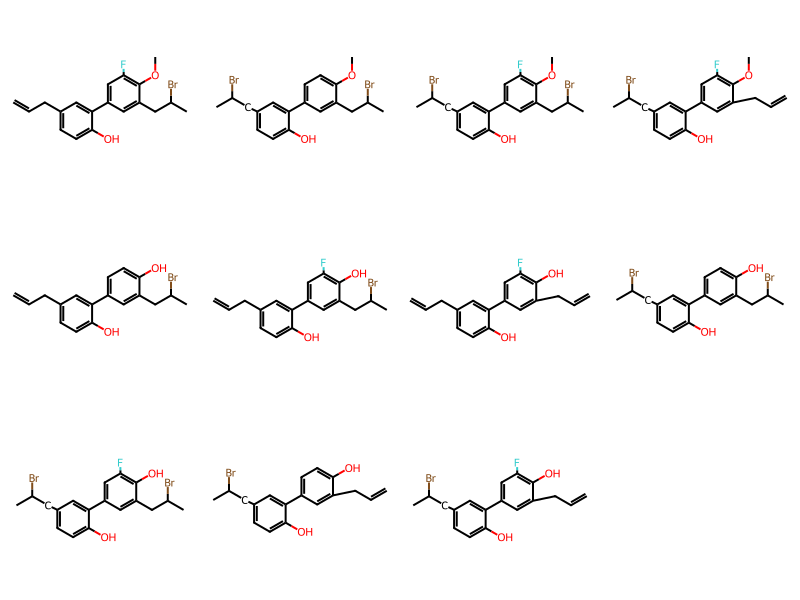

In [52]:
new_mols = []
oseen = {Chem.MolToSmiles(m) for m in matched_mols}
print(f'starting with {len(oseen)} original molecules and {len(sets)} candidates.')
nseen = set()
for ts in sets:
    mol = Chem.RemoveHs(Chem.molzip(ts))
    smi = Chem.MolToSmiles(mol)
    if smi in nseen or smi in oseen:
        continue
    new_mols.append(mol)
    nseen.add(smi)
print(len(new_mols))

Draw.MolsToGridImage(new_mols,molsPerRow=4)
    

### DCLV descriptors
v2024.03.1, update coming

Developer: Rachael Pirie

Rachael has a poster about this.

In [60]:
from rdkit.Chem import rdMolDescriptors

from rdkit.Chem import rdDistGeom
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f

mol = Chem.AddHs(Chem.MolFromSmiles('c1nc(CCC)ncc1'))
rdDistGeom.EmbedMolecule(mol,ps)

d = rdMolDescriptors.DoubleCubicLatticeVolume(mol,isProtein=False)
print(d.GetSurfaceArea())
print(d.GetVolume())
print(d.GetVDWVolume())


273.02912302420714
373.926501110657
125.07933140030887


### Interrupting long-running calculations
(ongoing)

Developer: David Cosgrove


Some potentially long-running calculations now respond sensibly to ctrl-C (or the "Interrupt Kernel" button in jupyter).

This, unfortunately, seems to not work particularly well in Jupyter on windows, so I can't demo it here.

Examples from running in the bash shell on Windows:
```
In [5]: m = Chem.AddHs(Chem.MolFromSmiles('CCCCCCCCCCCCCCCC'))

In [6]: rdDistGeom.EmbedMultipleConfs(m,1000,ps)
[13:07:03] Interrupted, cancelling conformer generation
Out[6]: <rdkit.rdBase._vectint at 0x242b20af240>

In [7]: m.GetNumConformers()
Out[7]: 0
```

Some of the other functionality currently supporting this are:
```
- `AssignCIPLabels()`
- Synthon space searches
- `DetermineConnectivity()`/`DetermineBonds()`
```

Another strategy for long-running calculations is to use time outs. 
Some of the functionality supporting timeouts are:
```
- Conformer generation
- CIP labelling
- Synthon space search
- RascalMCES
- FMCS
- RGD

```


In [95]:
from rdkit.Chem import rdDistGeom
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f
ps.timeout = 5
m = Chem.AddHs(Chem.MolFromSmiles('CCCCCCCCCCCCCCCC'))
rdDistGeom.EmbedMultipleConfs(m,1000,ps)

In [96]:
m.GetNumConformers()

0

### Some parameter objects no longer allow arbitrary values to be set
(ongoing)

Developer: Niels Maeder

Sometimes Python is *too* dynamic. It's nice to be able to add arbitrary data to things like molecules using attributes, but it is a frequent source of errors/confusion when working with parameters. 


In [16]:
m = Chem.MolFromSmiles('CCC')
m.foo = 'bar'
print(m.foo)

bar


In [45]:
from rdkit.Chem import rdDistGeom
ps = rdDistGeom.ETKDGv3()

ps.randomSeed = 0xf00d

In [ ]:
ps.randomseed

## New supported file formats

### MRV reading and writing
(2023.09)

Developer: Tad Hurst

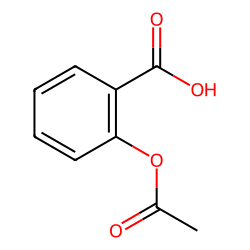

In [5]:
from rdkit import RDConfig
import os
IPythonConsole.molSize = 250,250

fn = os.path.join(RDConfig.RDBaseDir,'Code','GraphMol','MarvinParse','test_data','aspirin.mrv')
mol = Chem.MolFromMrvFile(fn)
mol


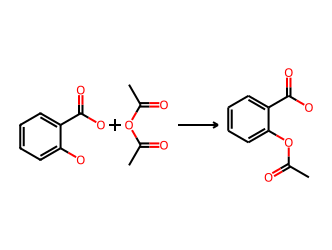

In [6]:
from rdkit.Chem import rdChemReactions
fn = os.path.join(RDConfig.RDBaseDir,'Code','GraphMol','MarvinParse','test_data','aspirineSynthesisWithAttributes.mrv')
rxn = rdChemReactions.ReactionFromMrvFile(fn)
rxn

We can write MRV as well:

In [7]:
mrv = Chem.MolToMrvBlock(mol,1,-1,1,1)
print(mrv[:1000])

<?xml version="1.0" encoding="windows-1252"?>
<cml xmlns="http://www.chemaxon.com" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.chemaxon.com http://www.chemaxon.com/marvin/schema/mrvSchema_20_20_0.xsd">
	<MDocument>
		<MChemicalStruct>
			<molecule molID="m1">
				<atomArray>
					<atom id="a1" elementType="C" x2="8.2077" y2="1.9251"/>
					<atom id="a2" elementType="C" x2="6.874" y2="1.1551"/>
					<atom id="a3" elementType="C" x2="6.874" y2="-0.3847"/>
					<atom id="a4" elementType="C" x2="8.2077" y2="-1.1545"/>
					<atom id="a5" elementType="C" x2="9.5415" y2="-0.3847"/>
					<atom id="a6" elementType="C" x2="9.5415" y2="1.1551"/>
					<atom id="a7" elementType="C" x2="10.8752" y2="1.9251"/>
					<atom id="a8" elementType="O" x2="10.8752" y2="3.4651"/>
					<atom id="a9" elementType="O" x2="12.2089" y2="1.1551"/>
					<atom id="a10" elementType="O" x2="10.8752" y2="-1.1549"/>
					<atom id="a11" elementType="C" x2="10.875" y2="-2.6949"/>
			

In [8]:
mrv = rdChemReactions.ReactionToMrvBlock(rxn,1)
print(mrv[:1000])

<?xml version="1.0" encoding="windows-1252"?>
<cml xmlns="http://www.chemaxon.com" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.chemaxon.com http://www.chemaxon.com/marvin/schema/mrvSchema_20_20_0.xsd">
	<MDocument>
		<MChemicalStruct>
			<reaction>
				<reactantList>
					<molecule molID="m1">
						<atomArray>
							<atom id="a1" elementType="C" x2="-10.8752" y2="1.4315"/>
							<atom id="a2" elementType="C" x2="-12.2089" y2="0.6615"/>
							<atom id="a3" elementType="C" x2="-12.2089" y2="-0.8783"/>
							<atom id="a4" elementType="C" x2="-10.8752" y2="-1.6483"/>
							<atom id="a5" elementType="C" x2="-9.5415" y2="-0.8783"/>
							<atom id="a6" elementType="C" x2="-9.5415" y2="0.6615"/>
							<atom id="a7" elementType="C" x2="-8.2077" y2="1.4315"/>
							<atom id="a8" elementType="O" x2="-8.2077" y2="2.9715"/>
							<atom id="a9" elementType="O" x2="-6.874" y2="0.6615"/>
							<atom id="a10" elementType="O" x2="-8.2077" y2="-1.6483"/

### CDX/CDXML
(2025.03.5, 2025.03.6)
Developer: Brian Kelley

Revvity have open sourced their parsers for the CDX and CDXML formats. Brian and the team at Glysade have done some cleanup work on that code base and wrapped it for use in the RDKit.


In [110]:
ms = Chem.MolsFromCDXMLFile('./Data/dimethylamine.cdx')
len(ms)

1

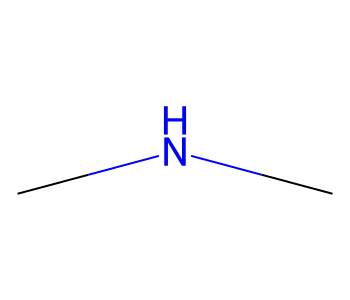

In [111]:
ms[0]

### SCSR: self-contained sequence representation
(2025.03.3)

Developer: Tad Hurst

SCSR is a file format created by the former MDL team (at Accelrys at the time).  It's derived from the Mol file (or SDF) format and is used to efficiently store molecules described by sequences of monomers (like proteins, DNA/RNA, sugars, polymers, etc). There's [a paper](https://doi.org/10.1021/ci2001988) as well as a description in the CTFile documentation.

Jonathan Bisson is going to say more about this.

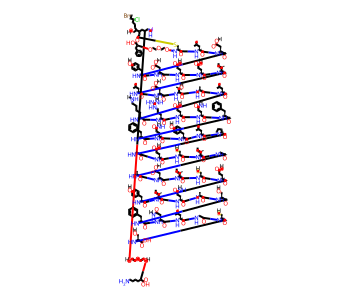

In [112]:
m = Chem.MolFromSCSRFile('c:/users/glandrum/RDKit_git/Code/GraphMol/FileParsers/test_data/macromols/ModifiedPeptide2.mol')
m

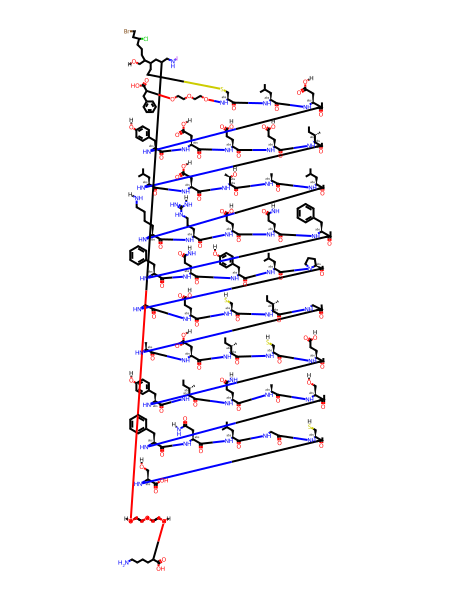

In [115]:
IPythonConsole.molSize = (450,600)
m

In [119]:
IPythonConsole.molSize = (350,300)

## MolStandardize improvements
(2023.09 release)

Many of the operations can now modify a molecule in place instead of making a copy.

Here's a silly example:

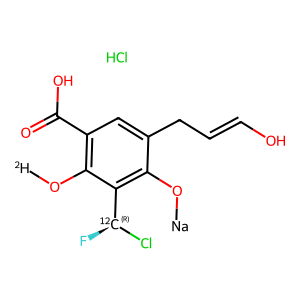

In [23]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
# the standardization code is verbose... disable that
RDLogger.DisableLog('rdApp.info')
IPythonConsole.molSize = 300,300
msm1 = Chem.MolFromSmiles('[Na]Oc1c([12C@H](F)Cl)c(O[2H])c(C(=O)O)cc1CC=CO.Cl')
msm1

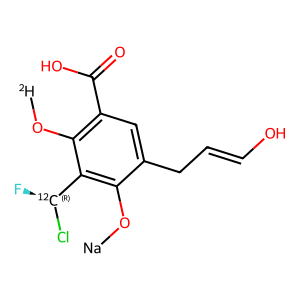

In [24]:
stripped = rdMolStandardize.RemoveFragments(msm1)
stripped

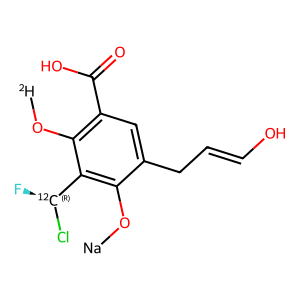

In [25]:
cp = Chem.Mol(msm1)
rdMolStandardize.RemoveFragmentsInPlace(cp)
cp


This can have a significant performance impact:

In [26]:
%timeit cp = Chem.Mol(msm1);rdMolStandardize.Normalize(cp)

892 µs ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%timeit cp = Chem.Mol(msm1);rdMolStandardize.NormalizeInPlace(cp)

731 µs ± 8.78 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
RDLogger.EnableLog('rdApp.info')


## Molecular interaction fields
(2025.03.1)

Developers: David Hahn/Greg Landrum

This is work David started in 2014 and that somehow never ended up being merged. I did the last bits of work and some modernization for the 2025.03.1 release.





In [135]:
from rdkit.Chem import rdMIF
m = Chem.SDMolSupplier('./Data/aligned_mols.sdf',removeHs=False)[0]
mif = rdMIF.ConstructGrid(m)
rdMIF.WriteToCubeFile(mif,'./Data/mol.cube',mol=m)
mif

## Improved support for organometallics
(ongoing, first in 2023.03)

Developer David Cosgrove, funded by Syngenta

Note: you will have *much* better luck in working with organometallics if you specify the number of H atoms (i.e. don't rely on implicit H calculations) for atoms bonded to metals and for the metals themselves. Being consistent and careful about this makes it much easier for the RDKit (or other chemistry toolkits) to understand what you mean.




In [58]:
from rdkit import Chem
from rdkit.Chem import Draw

In [59]:
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

### Part 1: adding a cleanup step to convert single bonds between metals and hypervalent atoms to dative bonds.

In [61]:
IPythonConsole.drawOptions.addAtomIndices = False

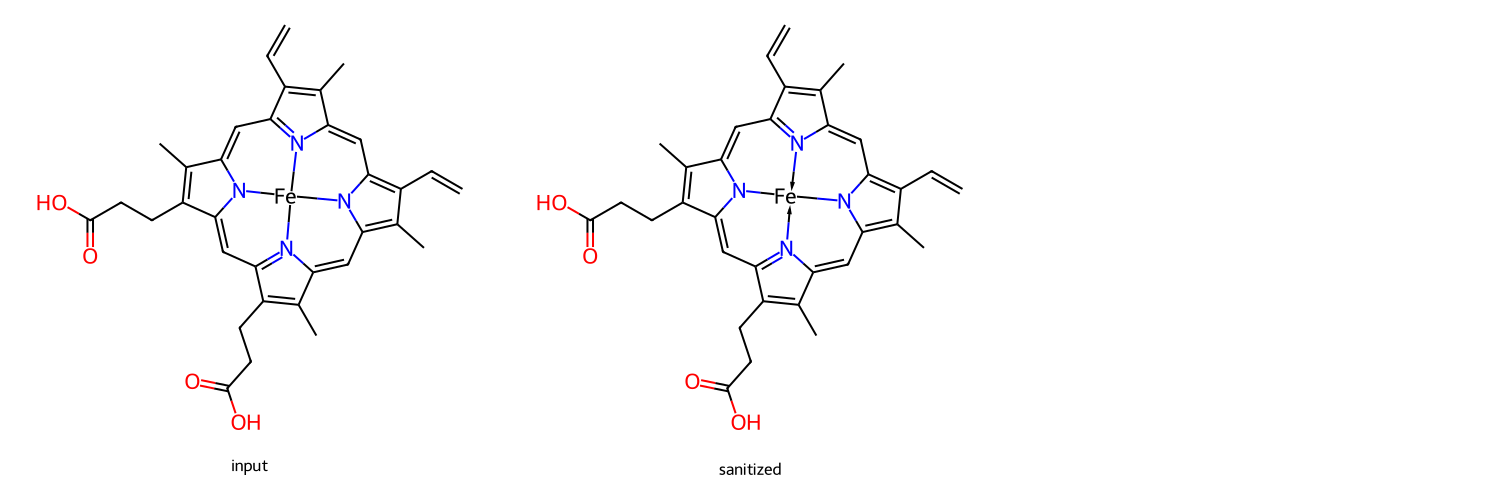

In [63]:
smiles='CC1=C(CCC(O)=O)C2=[N]3C1=Cc1c(C)c(C=C)c4C=C5C(C)=C(C=C)C6=[N]5[Fe]3(n14)n1c(=C6)c(C)c(CCC(O)=O)c1=C2'
m1 = Chem.MolFromSmiles(smiles,
                       sanitize=False)
m2 = Chem.MolFromSmiles(smiles)

m1.UpdatePropertyCache(strict=False)
Draw.MolsToGridImage((m1,m2),subImgSize=(500,500),legends=('input','sanitized'))

You can skip this step if you like by turning it off when you do sanitization:

In [64]:
m1 = Chem.MolFromSmiles(smiles,
                       sanitize=False)
Chem.SanitizeMol(m1,sanitizeOps = Chem.SANITIZE_ALL^Chem.SANITIZE_CLEANUP_ORGANOMETALLICS)

[17:27:06] unrecognized bond type[17:27:06] unrecognized bond type[17:27:26] unrecognized bond type[17:27:26] unrecognized bond type[17:27:39] unrecognized bond type[17:27:39] unrecognized bond type[17:30:37] Explicit valence for atom # 9 N, 4, is greater than permitted


AtomValenceException: Explicit valence for atom # 9 N, 4, is greater than permitted

### Part 2: Switching back and forth between dative and haptic representations

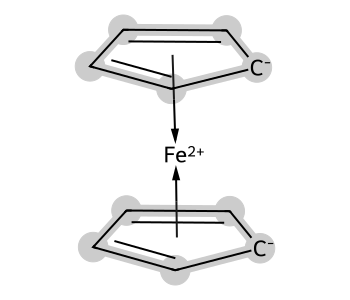

In [65]:
mb = '''ferrocene
     RDKit          2D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 12 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -34.237900 13.261800 0.000000 0 CHG=-1
M  V30 2 C -35.057400 14.266900 0.000000 0
M  V30 3 C -37.855700 14.284400 0.000000 0
M  V30 4 C -38.759100 13.293300 0.000000 0
M  V30 5 C -36.552000 12.683200 0.000000 0
M  V30 6 C -34.152900 8.363300 0.000000 0 CHG=-1
M  V30 7 C -34.972400 9.368400 0.000000 0
M  V30 8 C -37.770600 9.385900 0.000000 0
M  V30 9 C -38.674100 8.394800 0.000000 0
M  V30 10 C -36.450300 7.767900 0.000000 0
M  V30 11 Fe -36.435100 10.904500 0.000000 0 CHG=2
M  V30 12 * -36.522400 13.604600 0.000000 0
M  V30 13 * -36.404100 8.656100 0.000000 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 9 12 11 ENDPTS=(5 2 3 4 5 1) ATTACH=ALL
M  V30 2 1 1 5
M  V30 3 2 4 5
M  V30 4 1 4 3
M  V30 5 2 2 3
M  V30 6 1 1 2
M  V30 7 1 6 10
M  V30 8 2 9 10
M  V30 9 1 9 8
M  V30 10 2 7 8
M  V30 11 1 6 7
M  V30 12 9 13 11 ENDPTS=(5 7 8 9 10 6) ATTACH=ALL
M  V30 END BOND
M  V30 END CTAB
M  END
$$$$'''
m = Chem.MolFromMolBlock(mb)
m

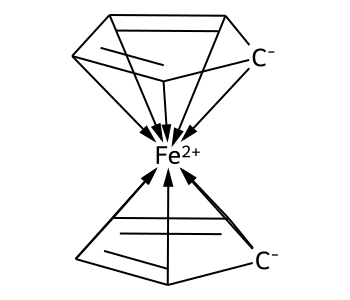

In [66]:
dative_m = Chem.HapticBondsToDative(m)
dative_m

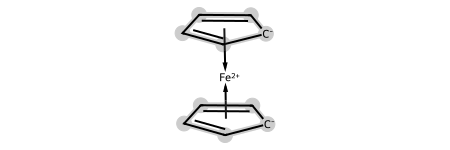

In [7]:
hapt_m = Chem.DativeBondsToHaptic(dative_m)
hapt_m

In [68]:
nm = Chem.Mol(dative_m)
nm.RemoveAllConformers()
Chem.MolToCXSmiles(nm)

'[cH]12[Fe+2]3456789([cH]1[cH]3[cH-]4[cH]25)[cH]1[cH]6[cH]7[cH-]8[cH]19 |C:0.0,2.1,3.4,4.6,5.9,6.10,7.12,8.14,9.16,10.19|'

In [8]:
m.Debug()

Atoms:
	0 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	6 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	7 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	8 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	9 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	10 26 Fe chg: 2  deg: 2 exp: 2 imp: 0 hyb: SP3
	11 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
	12 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
Bonds:
	0 11->10 order: D
	1 0->4 order: a conj?: 1 aromatic?: 1
	2 3->4 order: a conj?: 1 aromatic?: 1
	3 3->2 order: a conj?: 1 aromatic?: 1
	4 1->2 order: a conj?: 1 aromatic?: 1
	5 0->1 order: a conj?: 1 aromatic?: 1
	6 5->9 order: a conj?: 1 aromatic?: 1
	7 8->9 order: a conj?: 1

In [9]:
hapt_m.UpdatePropertyCache()
hapt_m.Debug()

Atoms:
	0 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	6 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	7 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	8 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	9 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	10 26 Fe chg: 2  deg: 2 exp: 2 imp: 0 hyb: SP3
	11 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
	12 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
Bonds:
	0 0->4 order: a conj?: 1 aromatic?: 1
	1 3->4 order: a conj?: 1 aromatic?: 1
	2 3->2 order: a conj?: 1 aromatic?: 1
	3 1->2 order: a conj?: 1 aromatic?: 1
	4 0->1 order: a conj?: 1 aromatic?: 1
	5 5->9 order: a conj?: 1 aromatic?: 1
	6 8->9 order: a conj?: 1 aromatic?: 1
	7 8-

### Disconnecting organometallics: sometimes it's better to just fragment the molecule and analyze the ligands and metal separately

In [69]:
from rdkit.Chem.MolStandardize import rdMolStandardize
Chem.MolToSmiles(rdMolStandardize.DisconnectOrganometallics(hapt_m))

[17:36:18] Initializing MetalDisconnector
[17:36:18] Running MetalDisconnector


'[Fe+2].c1cc[cH-]c1.c1cc[cH-]c1'

In [70]:
Chem.MolToSmiles(rdMolStandardize.DisconnectOrganometallics(dative_m))

[17:36:19] Initializing MetalDisconnector
[17:36:19] Running MetalDisconnector
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C
[17:36:19] Removed covalent bond between Fe and C


'[Fe+2].c1cc[cH-]c1.c1cc[cH-]c1'

By the way: you can make the MolStandardize code less verbose:

In [14]:
from rdkit import rdBase
with rdBase.BlockLogs():
    Chem.MolToSmiles(rdMolStandardize.DisconnectOrganometallics(dative_m))